In [1]:
# import essential libraries
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

# ml
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

## Data preprocessing

Data was scraped from Spotify, including 16 Vietnamese playlists with different genres. Please see the process [here](https://github.com/tvo10/DSCT/blob/main/Capstone/Data%20Wrangling/scrape_songs_metadata_from_spotify.ipynb).

The dataset has been cleaned; however, there would be some expected non-Vietnamese songs from the playlists added by the users. Please see the data wrangling process [here](https://github.com/tvo10/DSCT/blob/main/Capstone/Data%20Wrangling/song_genres_prediction_data_wrangling.ipynb).

In [2]:
vpop_df = pd.read_csv('https://raw.githubusercontent.com/tvo10/DSCT/main/Capstone/Data%20Wrangling/vpop.csv')
vpop_df.head()

names        artists  popularity  danceability  energy  key  \
0  Sài Gòn Đau Lòng Quá  Hứa Kim Tuyền          64         0.418   0.382    3   
1              LayLaLay     Jack - J97          60         0.549   0.568    6   
2     Xin Đừng Nhấc Máy          B Ray          58         0.873   0.755    7   
3   Có Lẽ Anh Chưa Từng         Only C          48         0.635   0.439    9   
4           Cho Mình Em           Binz          56         0.603   0.412    0   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    -7.778     1       0.0319        0.7860          0.000001    0.3860   
1    -8.159     0       0.1760        0.0859          0.000000    0.0863   
2    -4.506     1       0.1400        0.2930          0.000000    0.0881   
3   -10.434     0       0.0444        0.6090          0.000000    0.2000   
4   -10.359     1       0.0579        0.8910          0.021200    0.1150   

   valence    tempo  duration_min    year  
0    0.261  163.878      5.144817  2021.0  
1    0.351  174.038      3.862067  2021.0  
2    0.773   94.017      3.124233  2021.0  
3    0.661  147.871      4.908917  2021.0  
4    0.371   99.886      3.440000  2021.0

In [3]:
vpop_df.dtypes

names                object
artists              object
popularity            int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_min        float64
year                float64
dtype: object

Since year is not int, we need to convert it.

In [4]:
# Convert year from float to int
vpop_df['year'] = vpop_df['year'].fillna(2010).astype('int64')

## Explore Data

Let's start to explore the dataset!!!

In [5]:
# Improve the quality for plots
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

### Decade

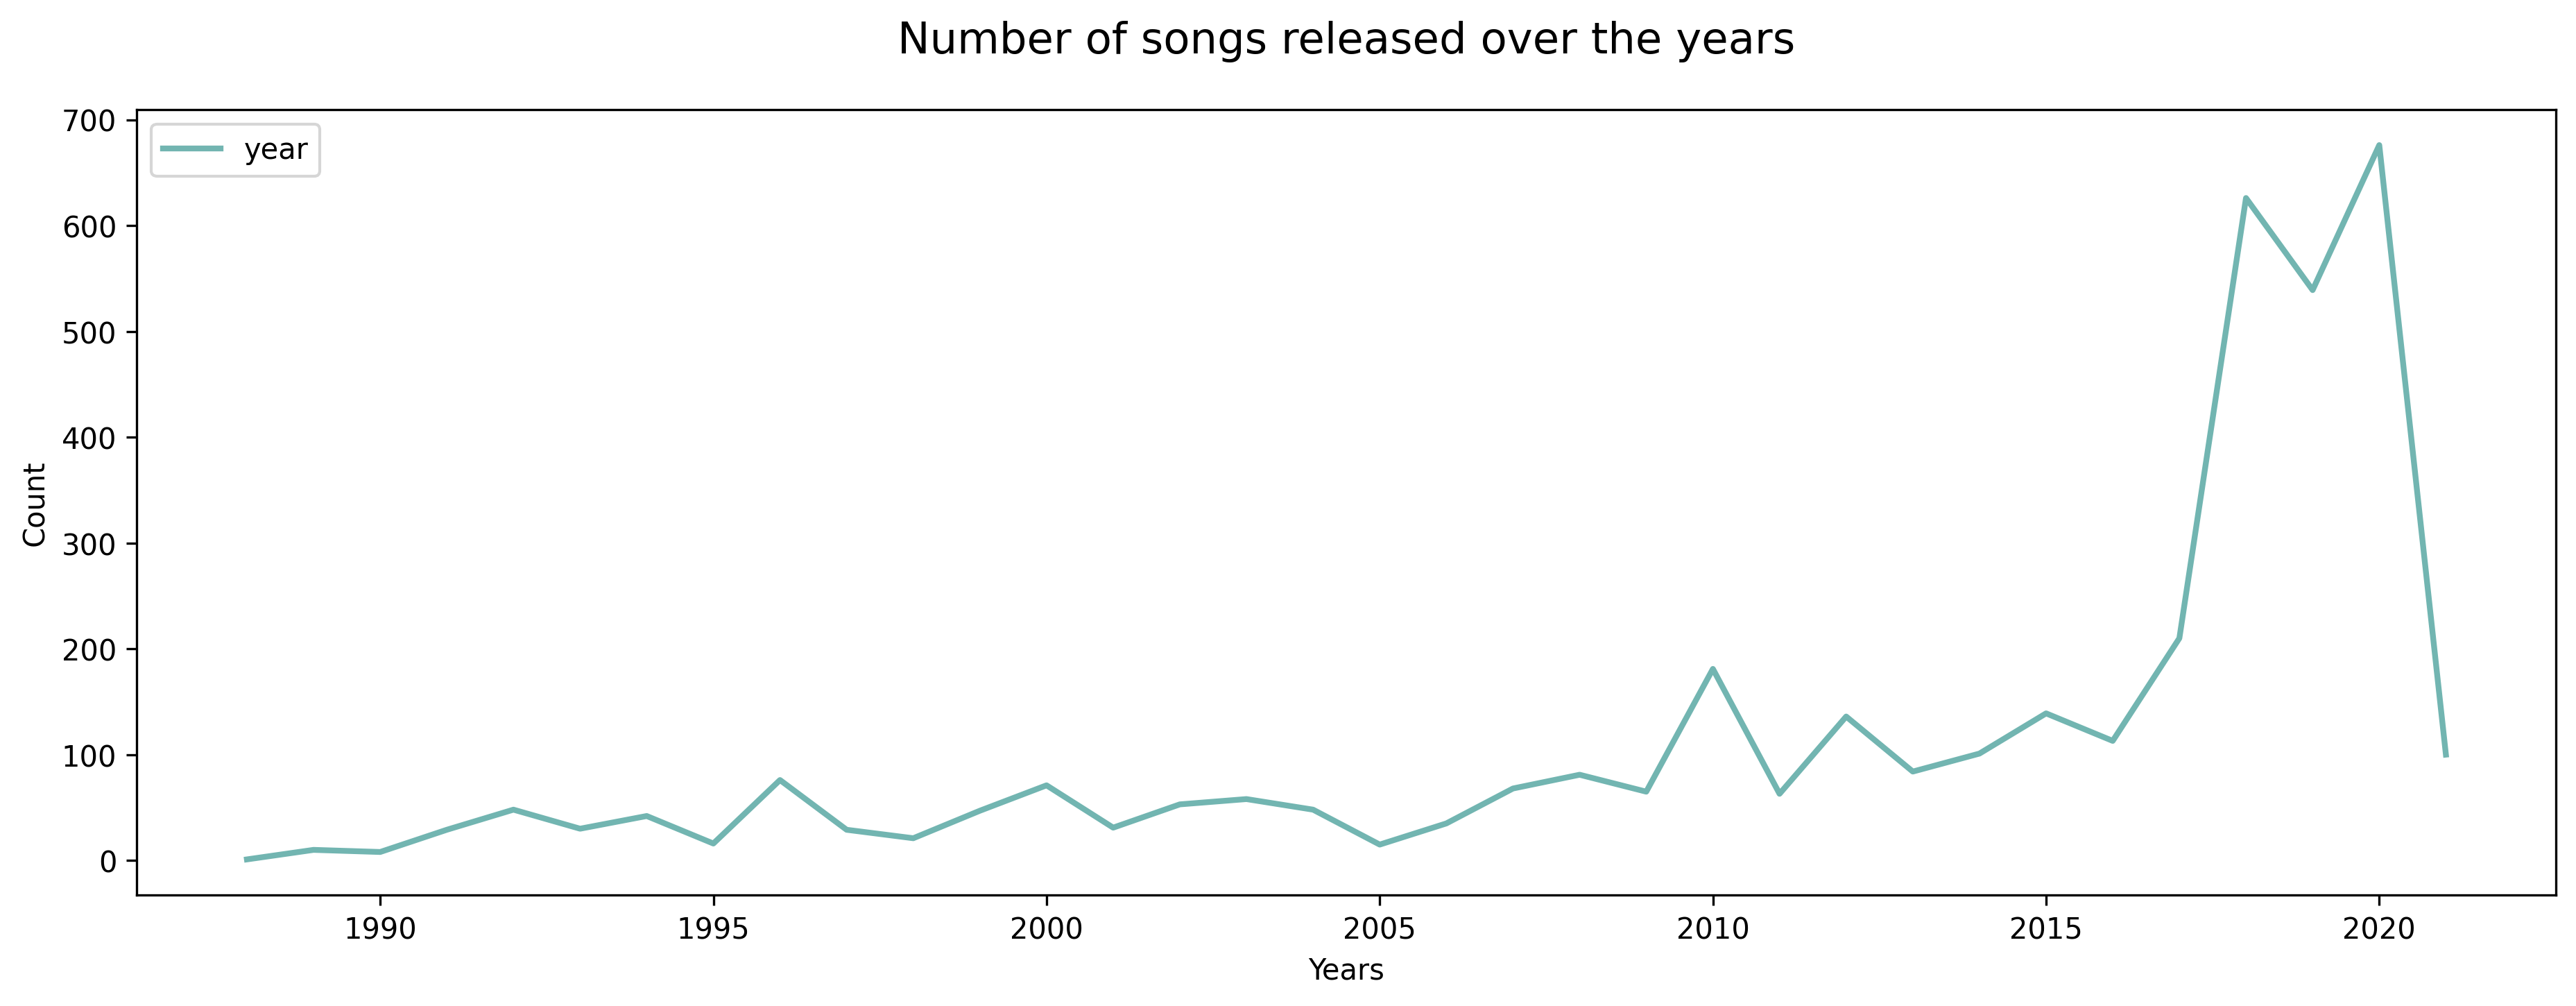

In [6]:
year = pd.DataFrame(vpop_df['year'].value_counts())
year = year.sort_index()
song_year = year.plot(kind='line', figsize=(15,5), color='#72b5b1', linewidth=2)
plt.title("Number of songs released over the years", y=1.05, fontsize=15)
plt.xlabel('Years')
plt.ylabel('Count')
song_year.axes.get_xaxis().set_visible(True)
plt.show()

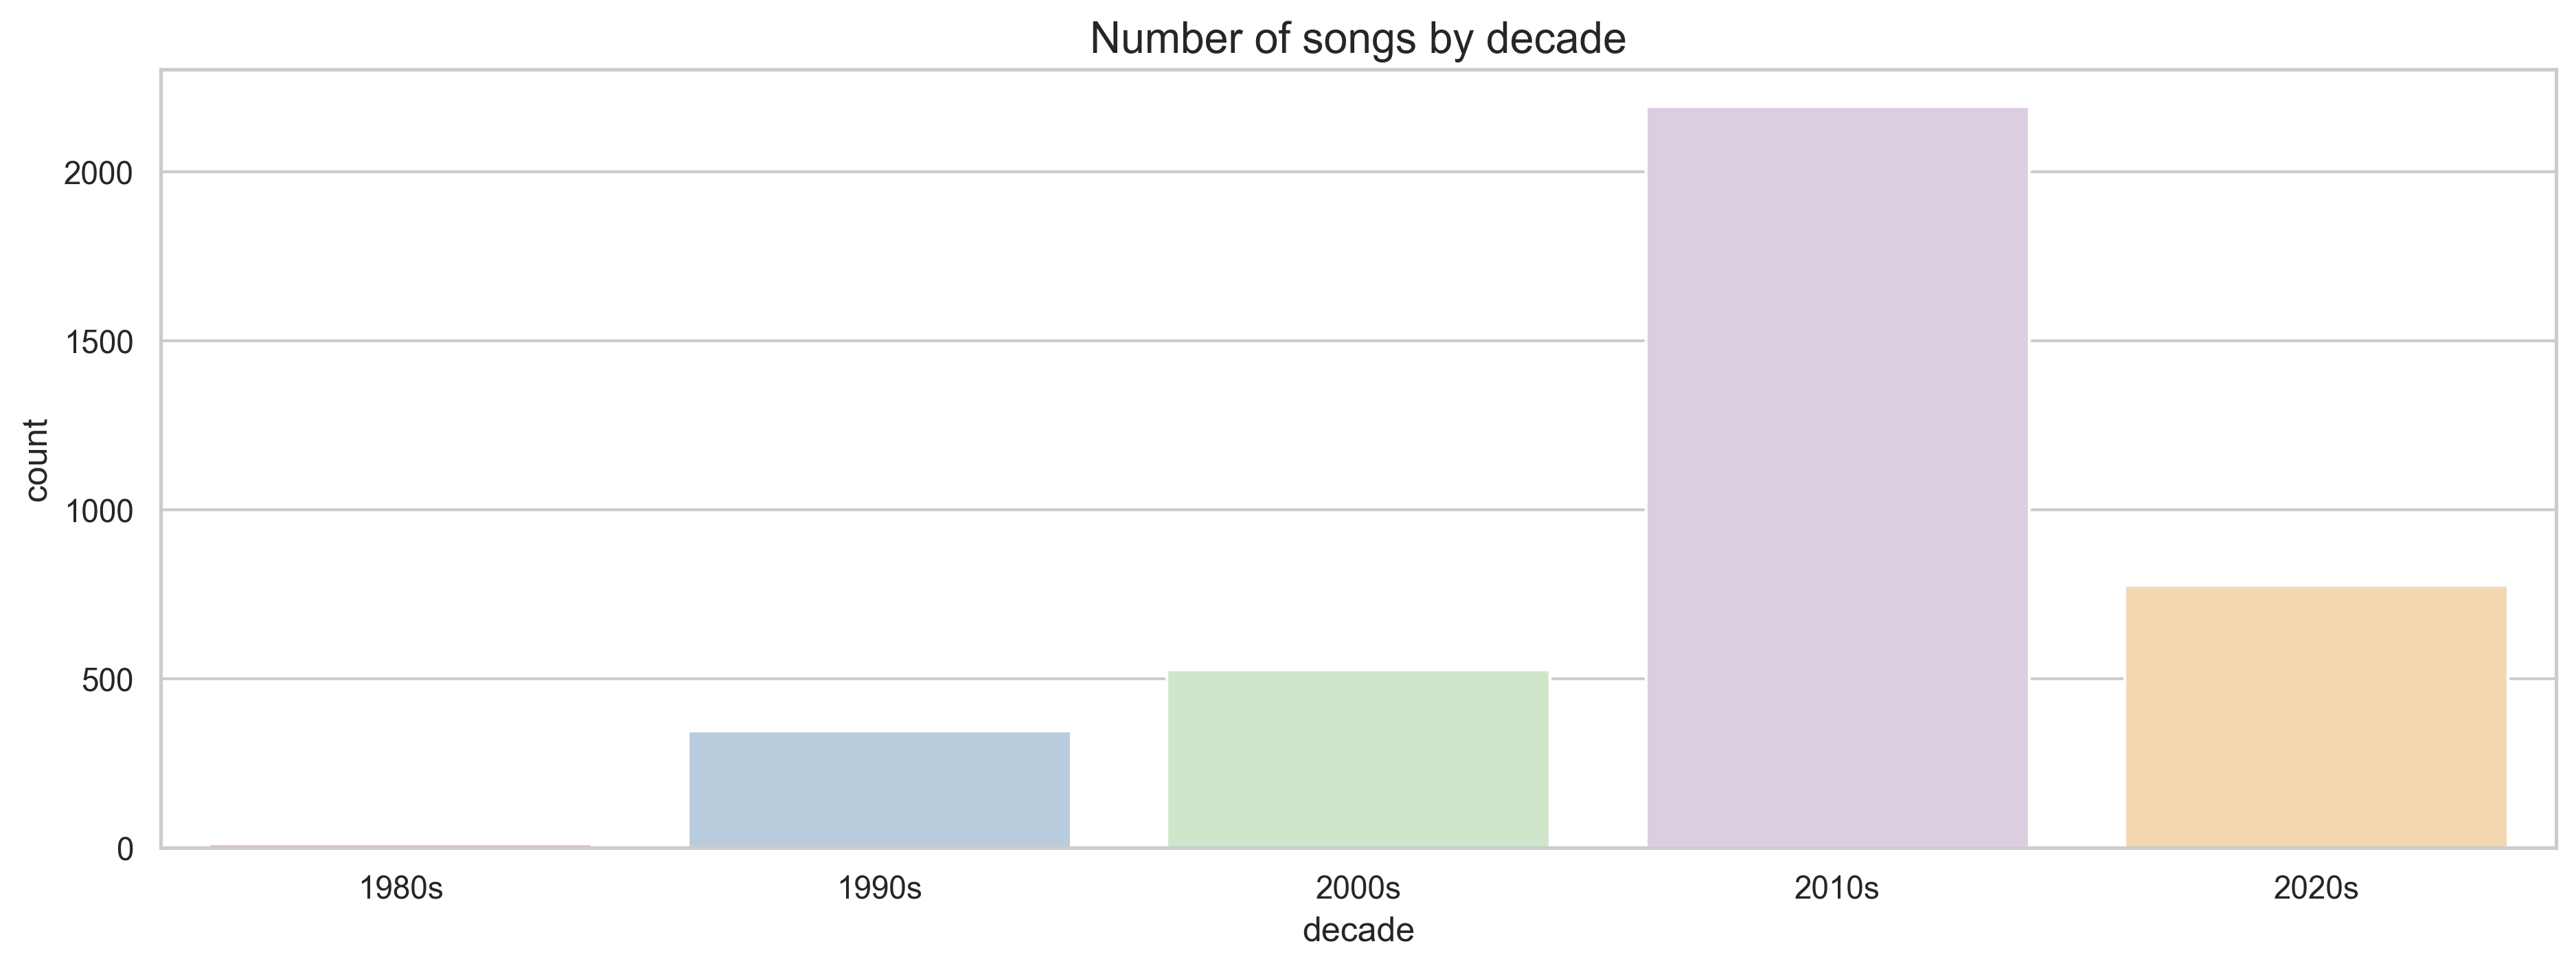

In [7]:
# define a function to convert year to decade
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade
vpop_df['decade'] = vpop_df['year'].apply(get_decade)

# set up plots
sns.set(rc={'figure.figsize':(15 ,5)})
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_palette('Pastel1')
sns.set_style('whitegrid')

# plot
axis = sns.countplot(x= vpop_df['decade'].sort_values(), data=vpop_df)
axis.set_title('Number of songs by decade', fontsize=15)
plt.show()

It seems like most of the songs in the dataset are released in 2010s. 

### Popular Tracks

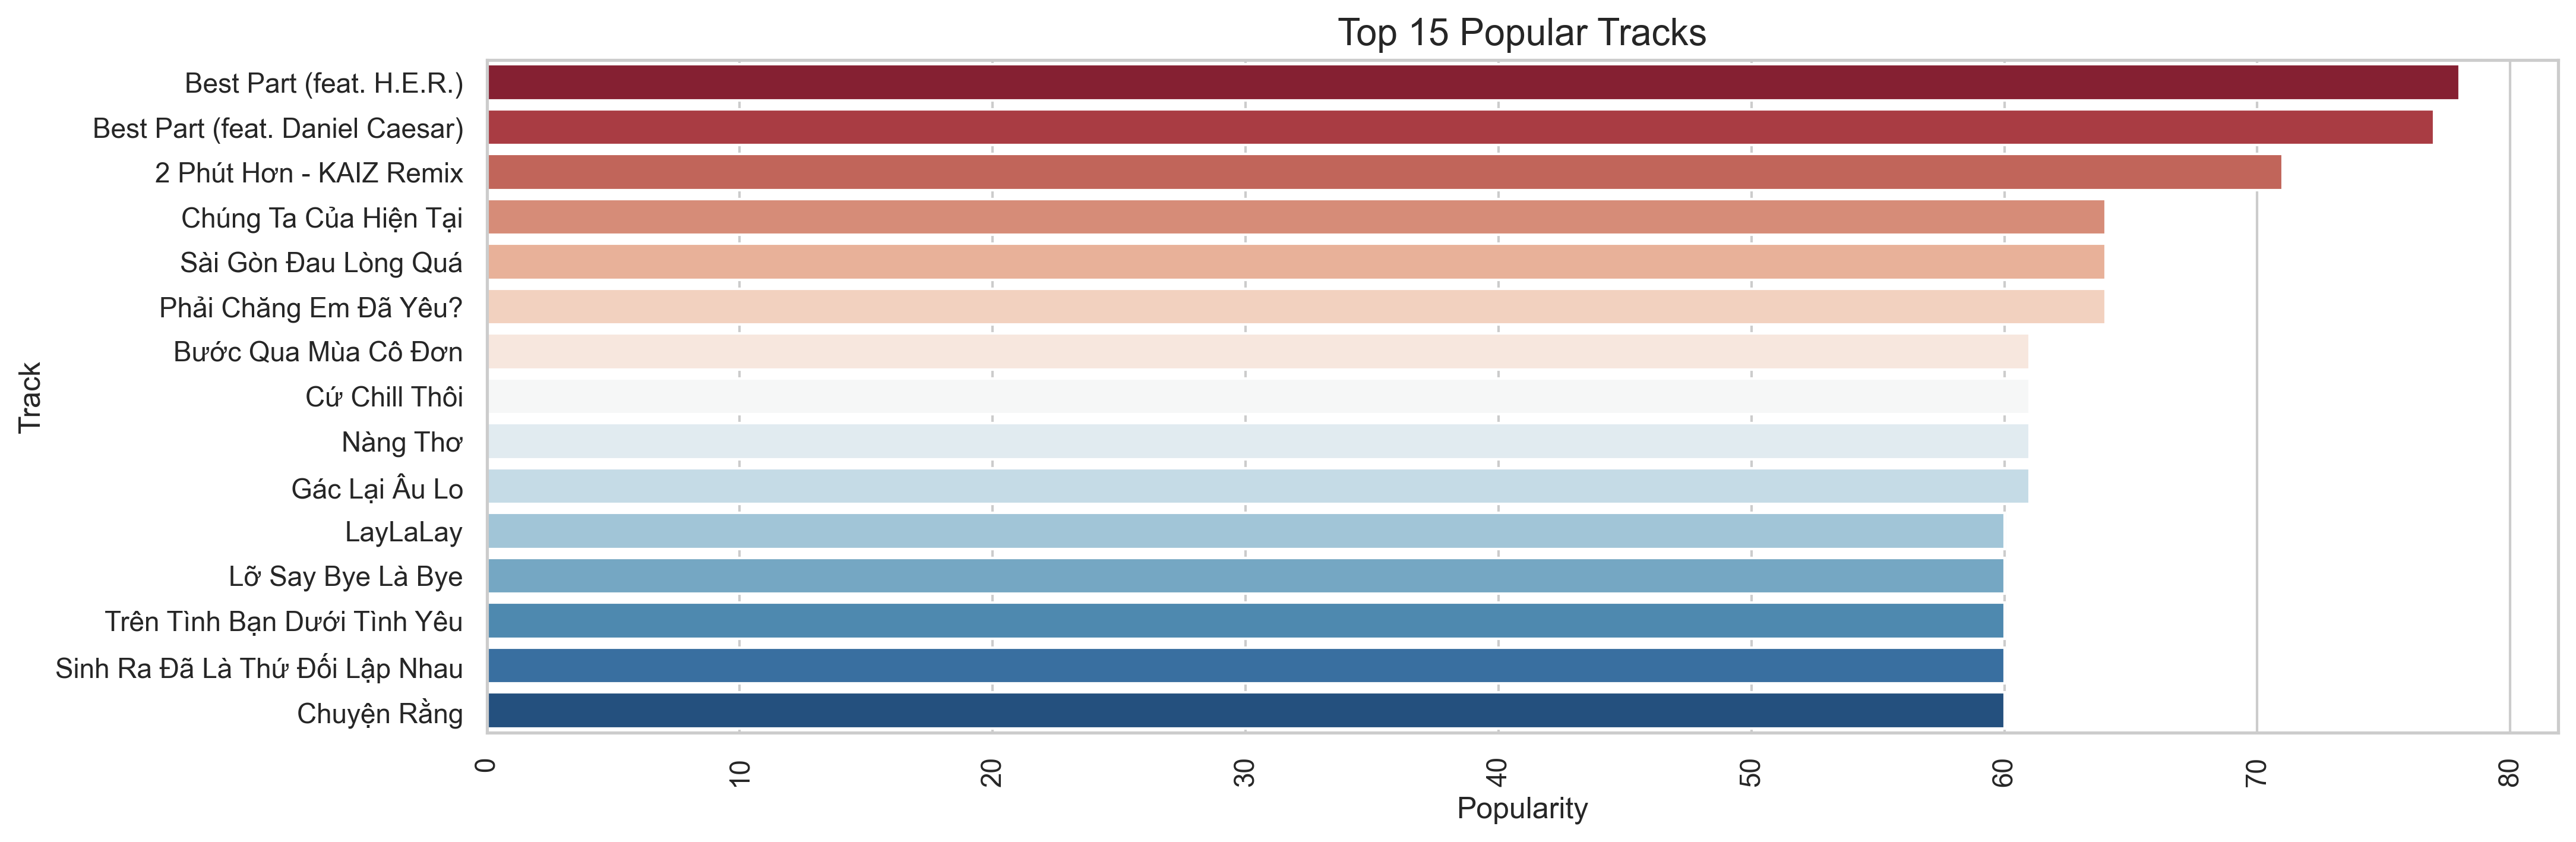

In [8]:
# Most Popular Tracks
track_popular = vpop_df.groupby('names')['popularity'].mean().sort_values(ascending=False).head(15)
fig, axis = plt.subplots(figsize = (15, 5))
axis = sns.barplot(x=track_popular, y=track_popular.index, palette='RdBu', orient = 'h')
axis.set_title('Top 15 Popular Tracks', fontsize=15)
axis.set_ylabel('Track')
axis.set_xlabel('Popularity')
plt.xticks(rotation = 90)
plt.show()

Oh no, there are two songs that not Vietnamese songs in the top two. Let's remove them.

In [9]:
vpop_df = vpop_df[(vpop_df['names'] != 'Best Part') & (vpop_df['names'] != 'Best Part (feat. Daniel Caesar)') & (vpop_df['names'] != 'Best Part (feat. H.E.R.)')]

We need to double check to see if we successfully removed them.

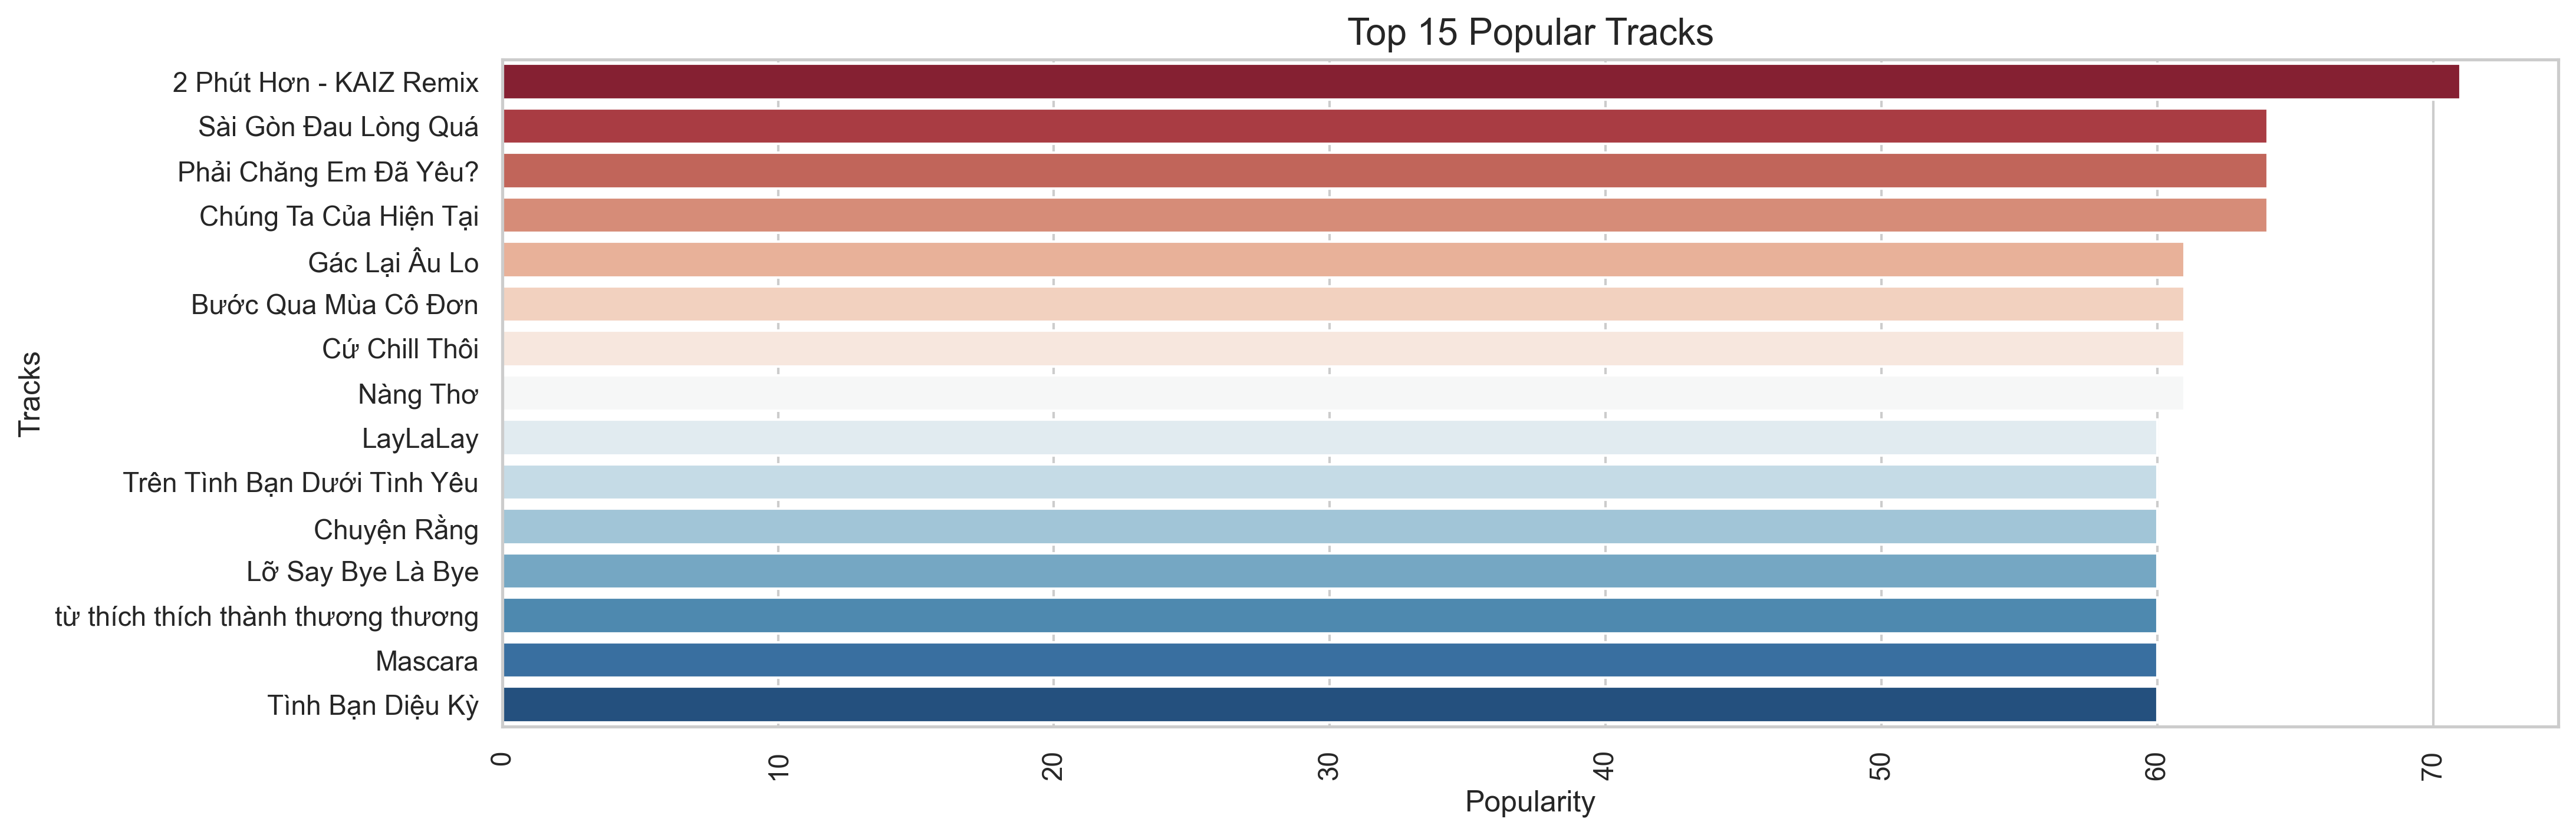

In [10]:
# Most Popular Tracks
track_popular = vpop_df.groupby('names')['popularity'].mean().sort_values(ascending=False).head(15)
axis = sns.barplot(x= track_popular, y=track_popular.index, palette='RdBu', orient = 'h')
axis.set_title('Top 15 Popular Tracks', fontsize=15)
axis.set_ylabel('Tracks')
axis.set_xlabel('Popularity')
plt.xticks(rotation = 90)
plt.show()

Yayy! Now the top 15 popular tracks are all Vietnamese songs. 

### Popular Artists

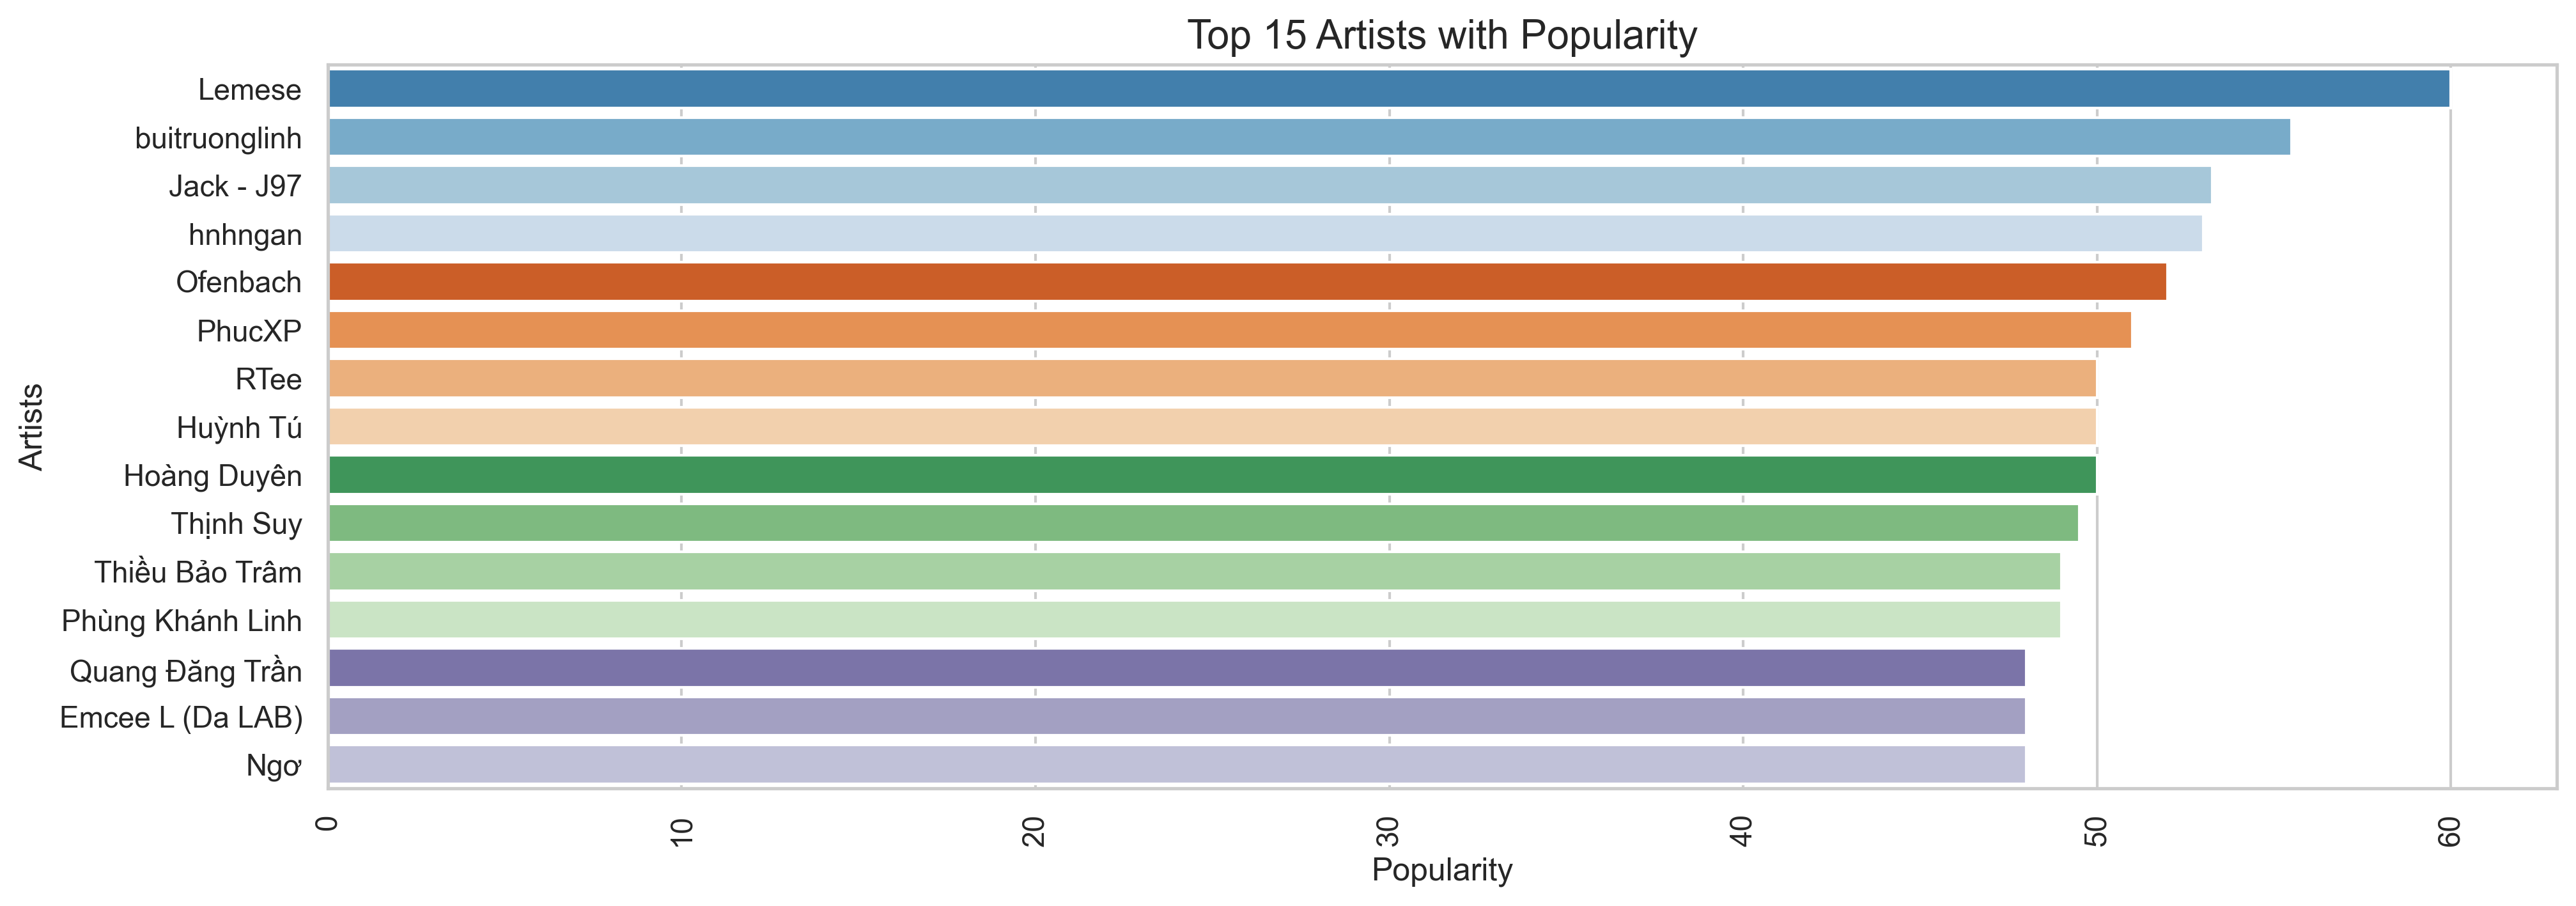

In [11]:
# Most Popular Artists
popular = vpop_df.groupby('artists')['popularity'].mean().sort_values(ascending=False)[:15]
axis = sns.barplot(x=popular, y=popular.index, palette='tab20c', orient = 'h')
axis.set_title('Top 15 Artists with Popularity', fontsize=15)
axis.set_ylabel('Artists')
axis.set_xlabel('Popularity')
plt.xticks(rotation = 90)
plt.show()

Lemese appears to be the most popular artist based on the popularity.

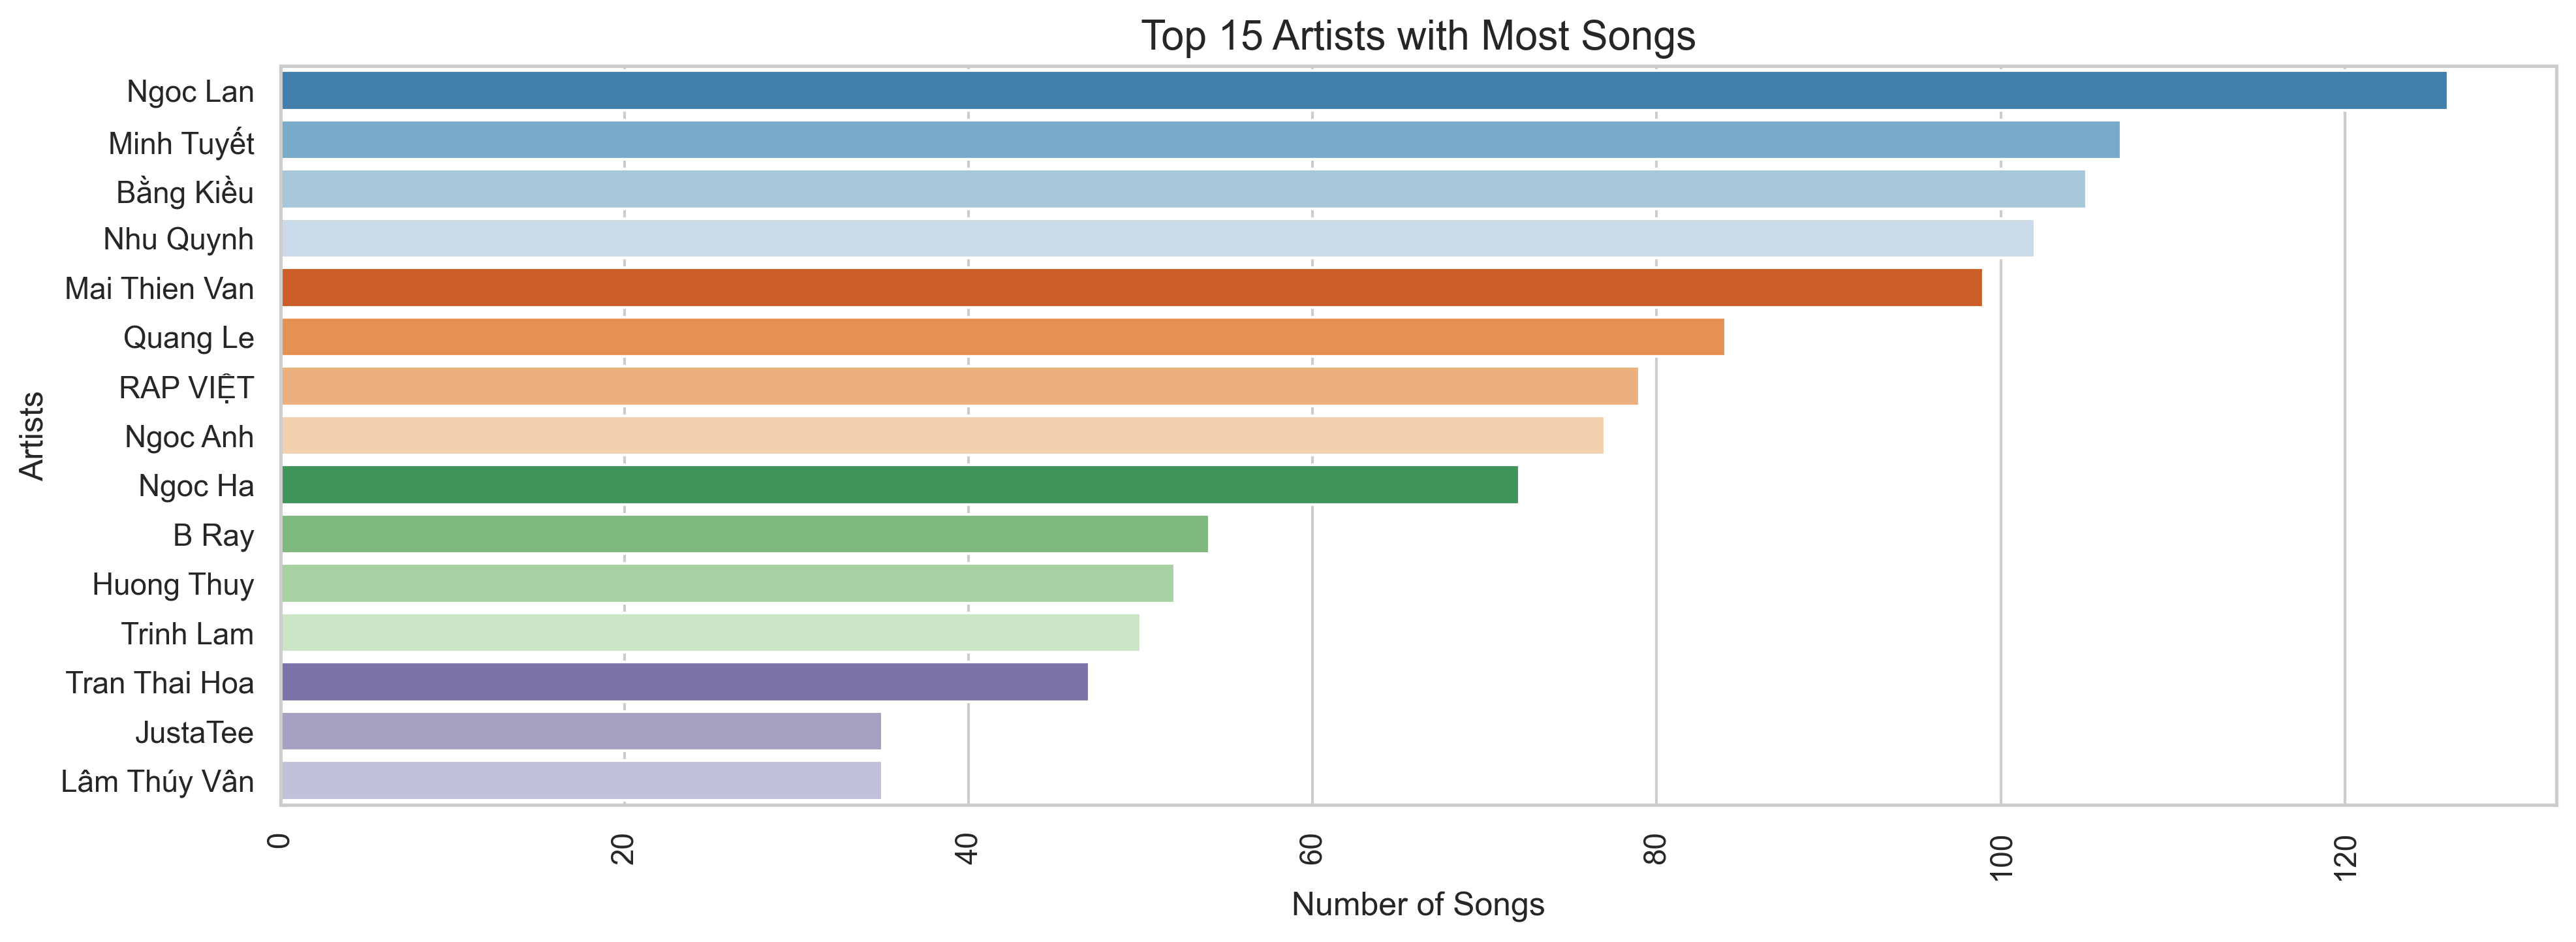

In [12]:
# Artists released most songs
most_songs = pd.DataFrame(vpop_df['artists'].value_counts()).reset_index()
most_songs.columns=['Artists','Songs_Count']
artists_songs = most_songs.groupby('Artists')['Songs_Count'].sum().sort_values(ascending=False)[:15]
axis = sns.barplot(x=artists_songs, y=artists_songs.index, palette='tab20c', orient = 'h')
axis.set_title('Top 15 Artists with Most Songs', fontsize=15)
axis.set_ylabel('Artists')
axis.set_xlabel('Number of Songs')
plt.xticks(rotation = 90)
plt.show()

Ngoc Lan is a singer that released the most songs.

### Features

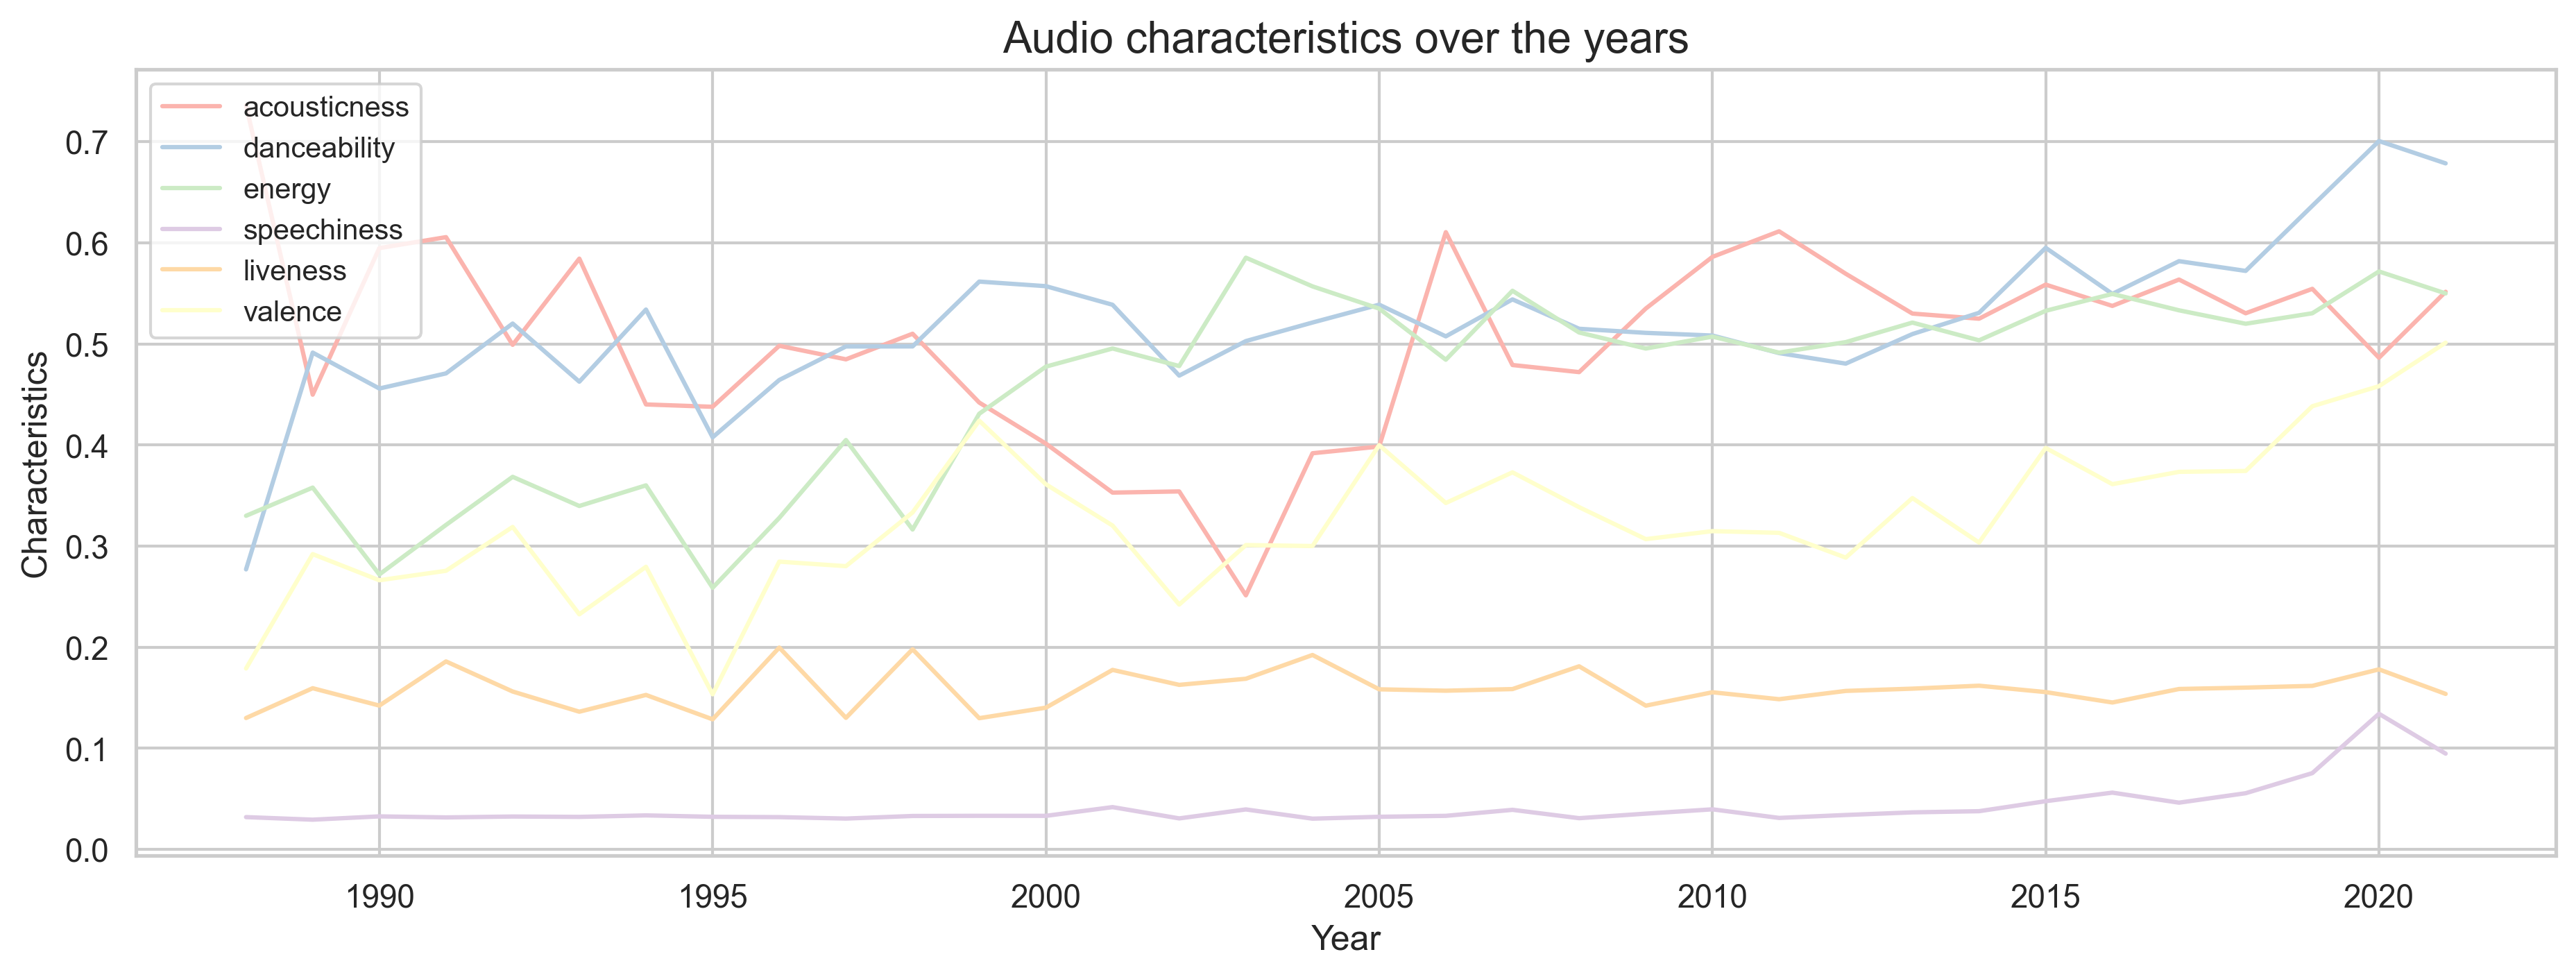

In [13]:
# Audio characteristics over the years
columns = ['acousticness', 'danceability', 'energy', 'speechiness', 'liveness', 'valence']
for i in columns:
    x = vpop_df.groupby('year')[i].mean()
    sns.lineplot(x=x.index, y=x, label=i)
plt.title('Audio characteristics over the years', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Characteristics')
plt.legend(prop={'size': 10}, loc = 'upper left')
plt.show()

Interestingly! Danceability is the most favour audio characteristic over the years.

### Mean of Features

In [14]:
# create a small dataframe that holds all the audio features with value less than 1
features_small = vpop_df[['danceability', 'energy', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']]

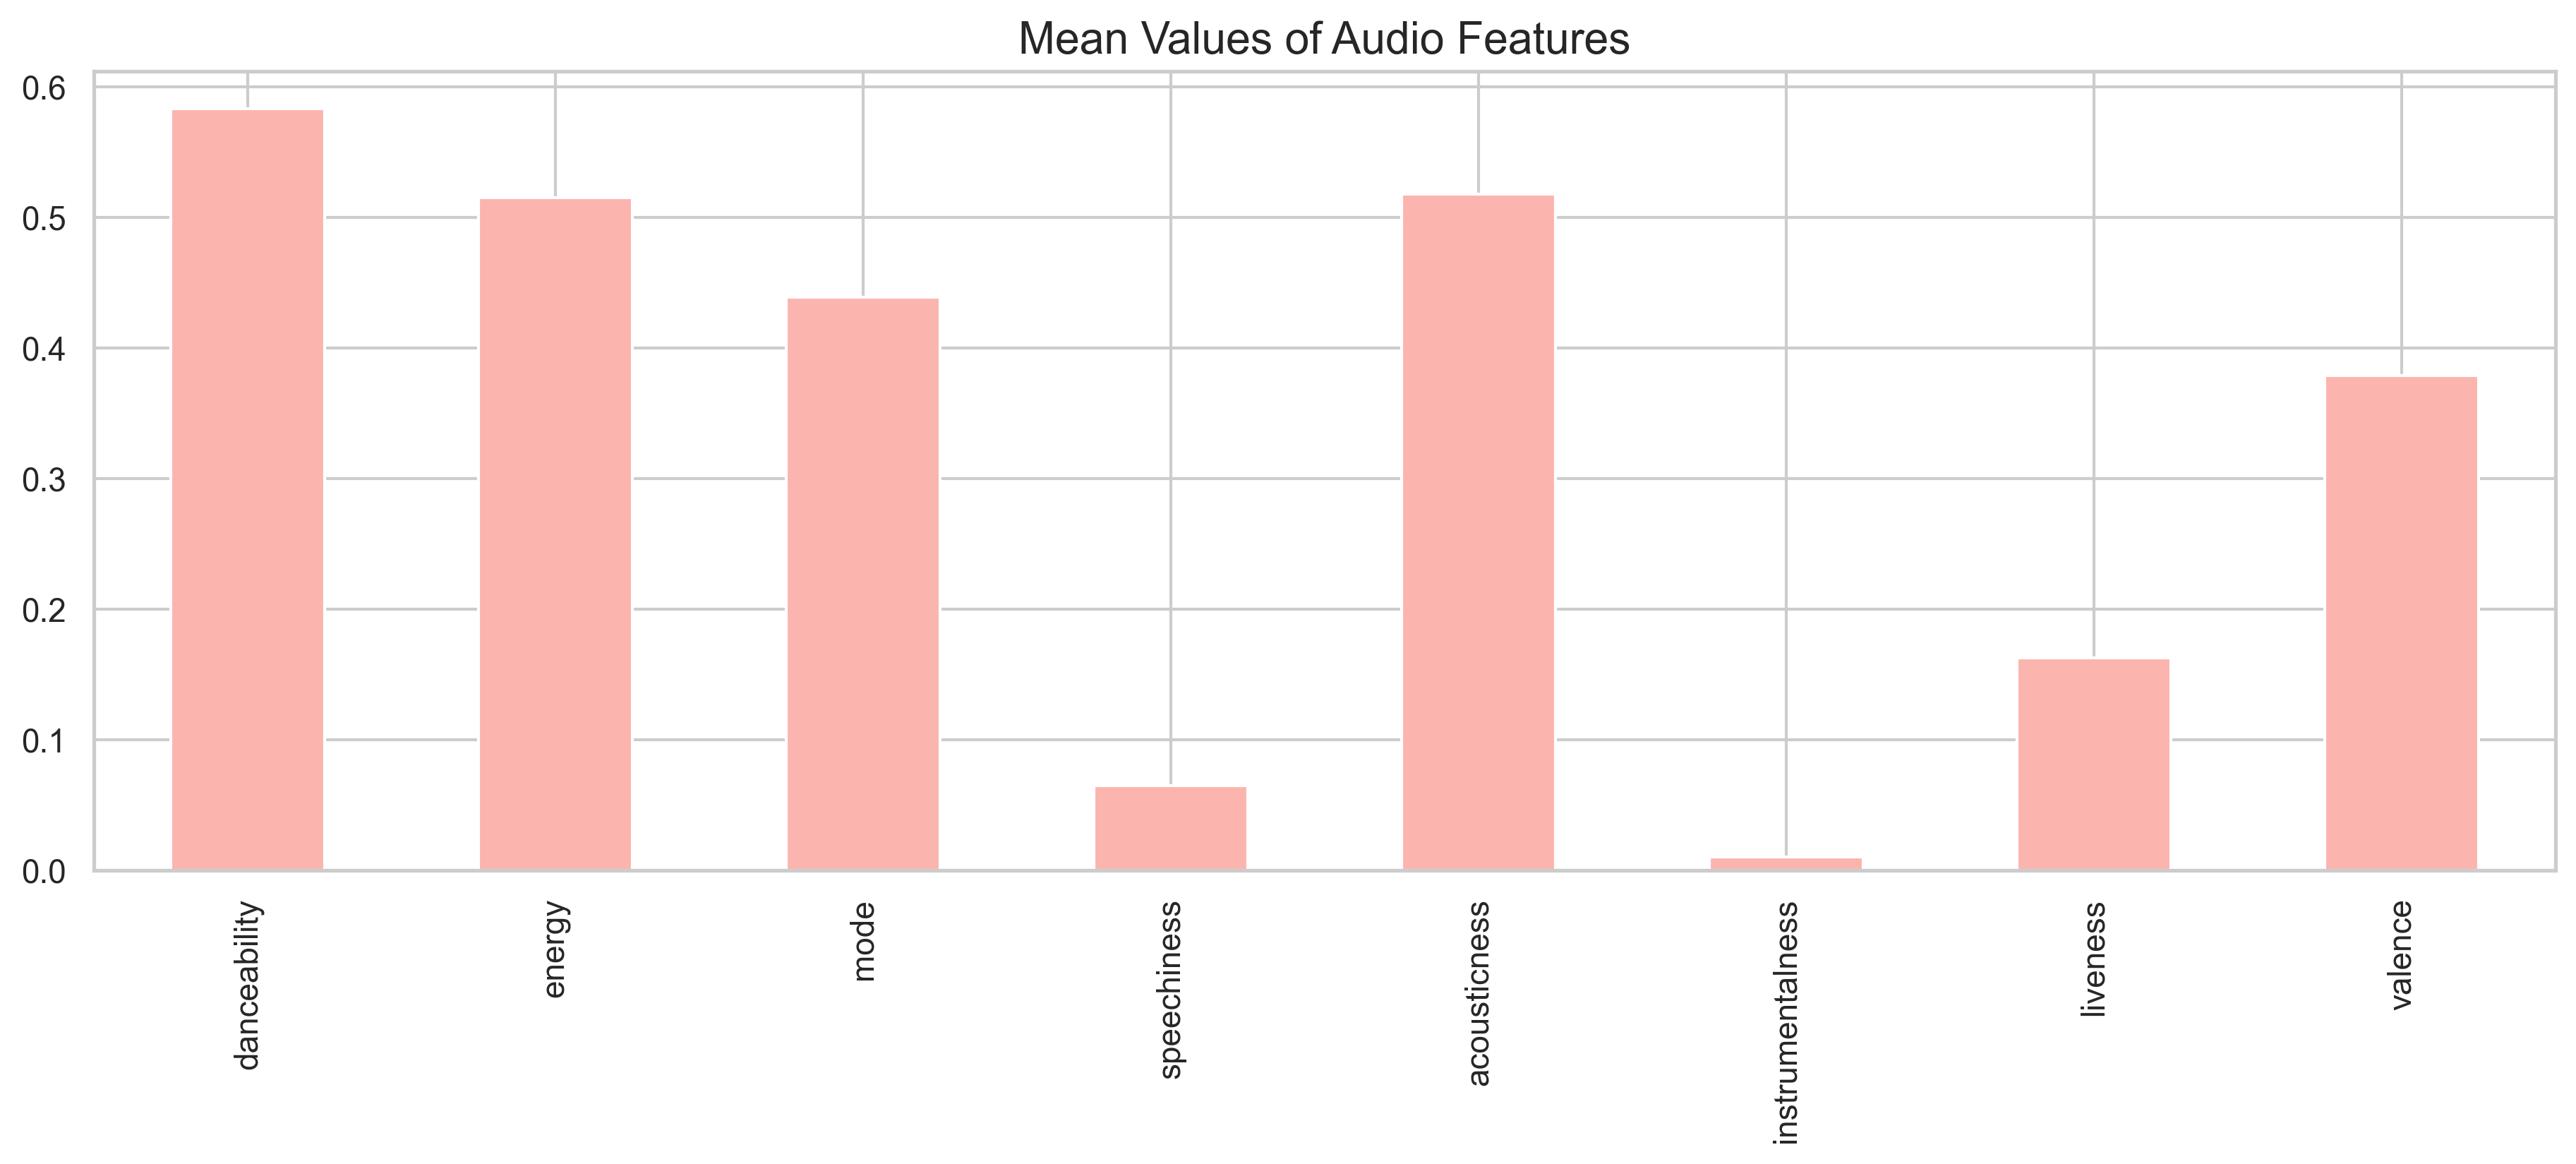

In [15]:
# bar chart of the mean values of all audio features in features_small dataset
features_small.mean().plot.bar()
plt.title('Mean Values of Audio Features', fontsize=15)
plt.show() 

Amongst all features, danceability has the highest mean.

### Danceability

Mean value for danceability: 0.5829513906940481


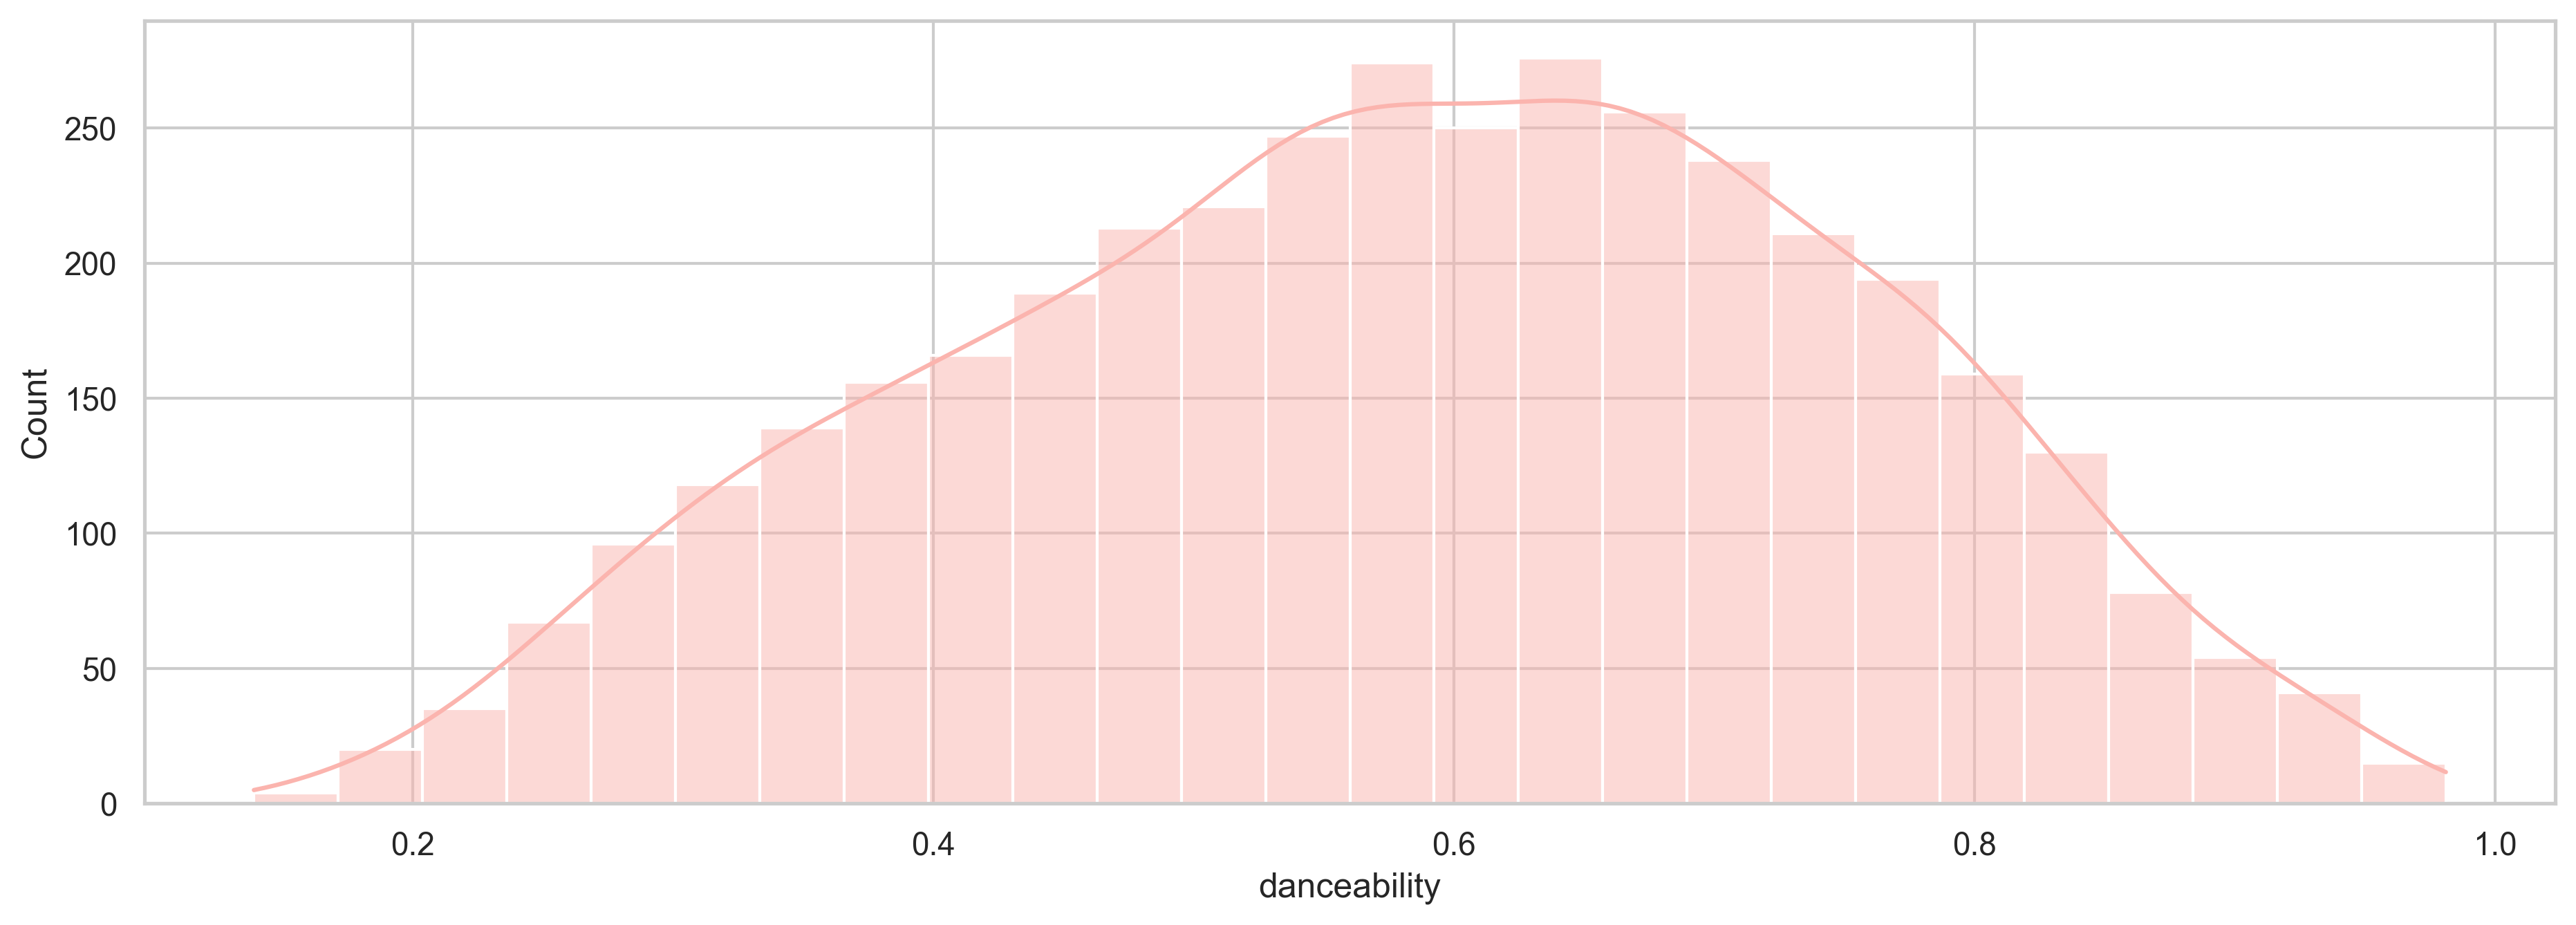

In [16]:
# mean value and histplot for danceability feature
print("Mean value for danceability:", vpop_df['danceability'].mean())
sns.histplot(vpop_df['danceability'], kde=True)
plt.show()

With a mean value of 0.583, it seems like the majority of the Vietnamese tracks have a high danceability rating.

Mean value for energy: 0.51532292695607


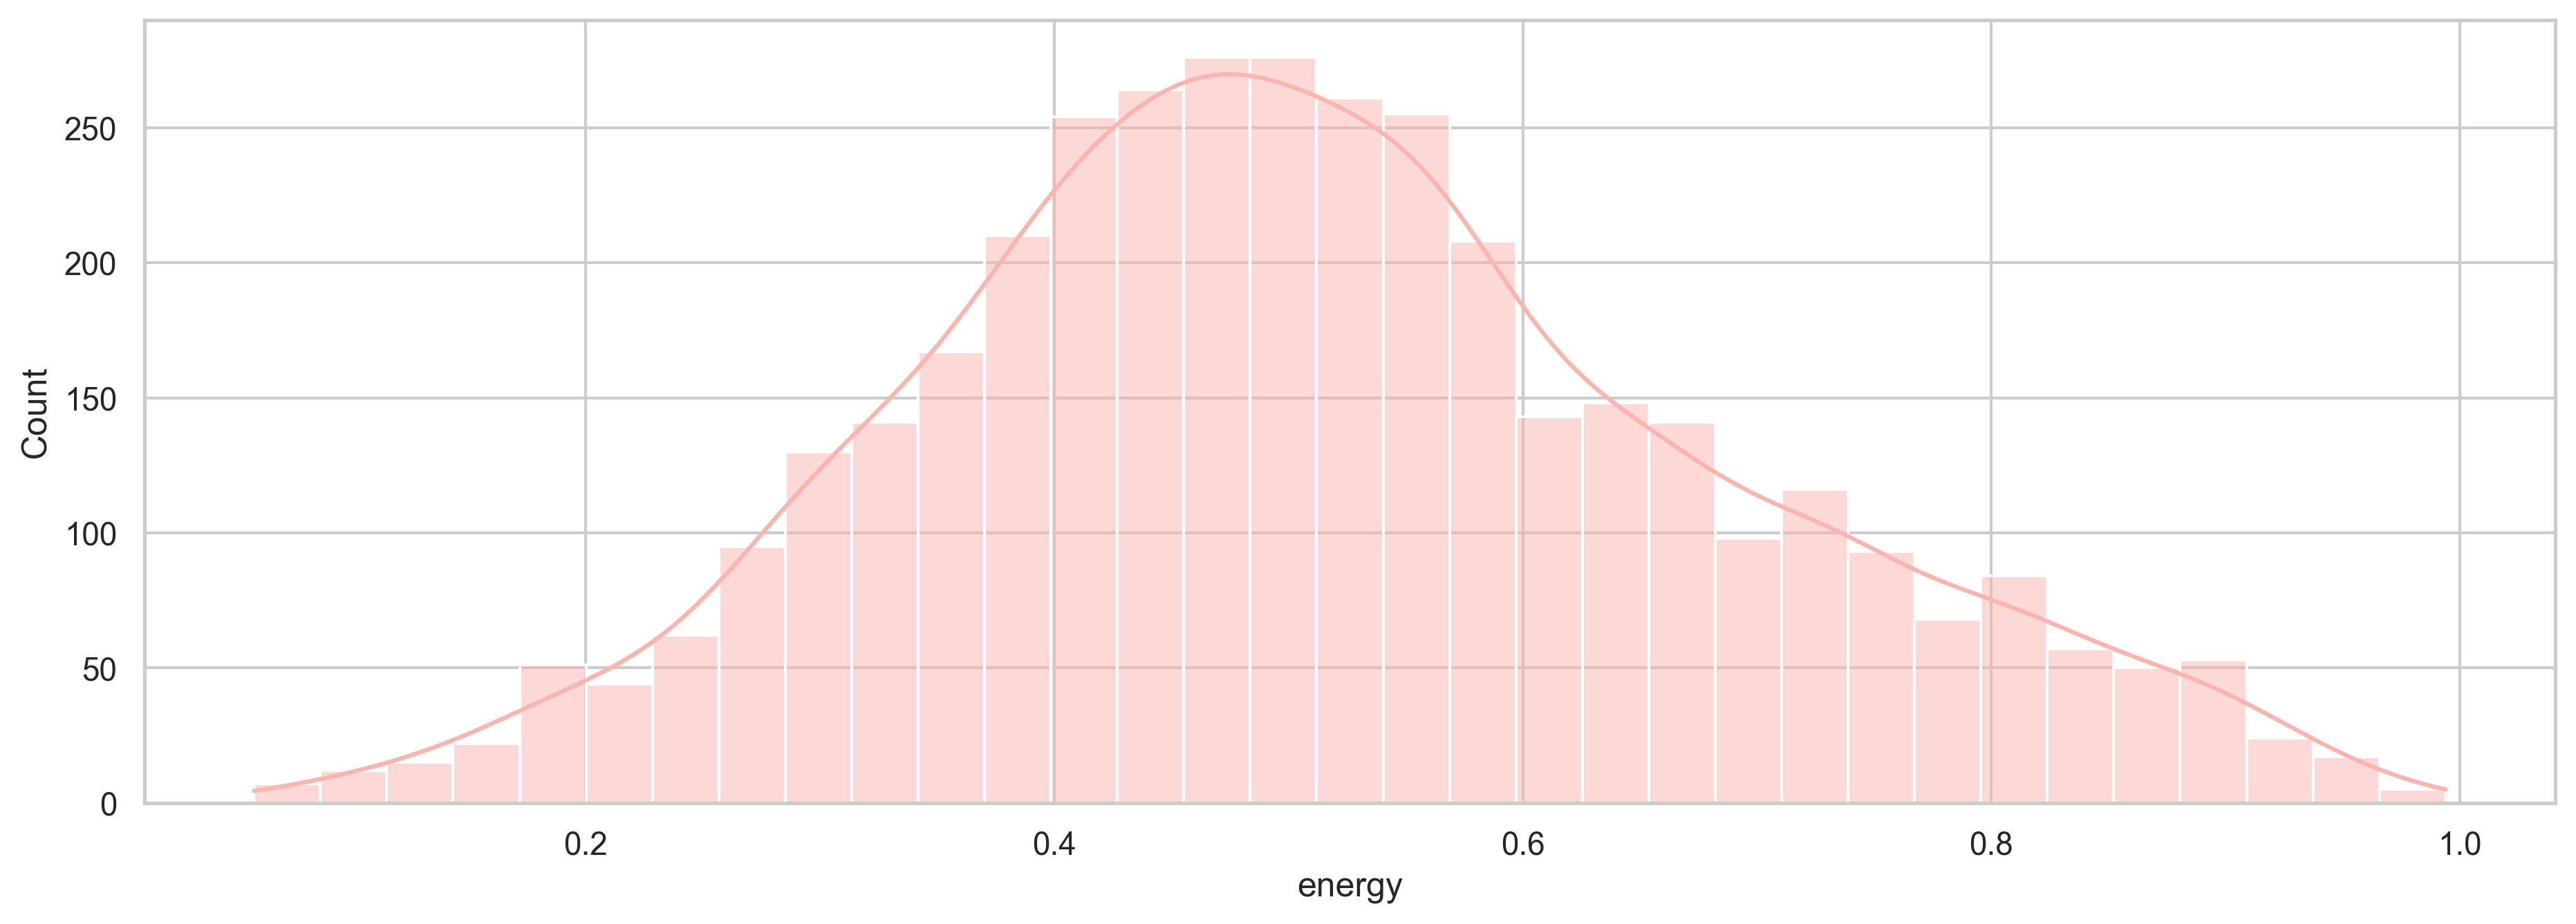

In [17]:
# mean value and histplot for for energy feature
print("Mean value for energy:", vpop_df['energy'].mean())
sns.histplot(vpop_df['energy'], kde=True)
plt.show()

Similar to danceability feature, with a mean value of 0.515, it seems like the majority of the Vietnamese tracks have a high energy rating. Thus, we can say that Vietnamese are likely to stream songs they can dance to or give them energy. 

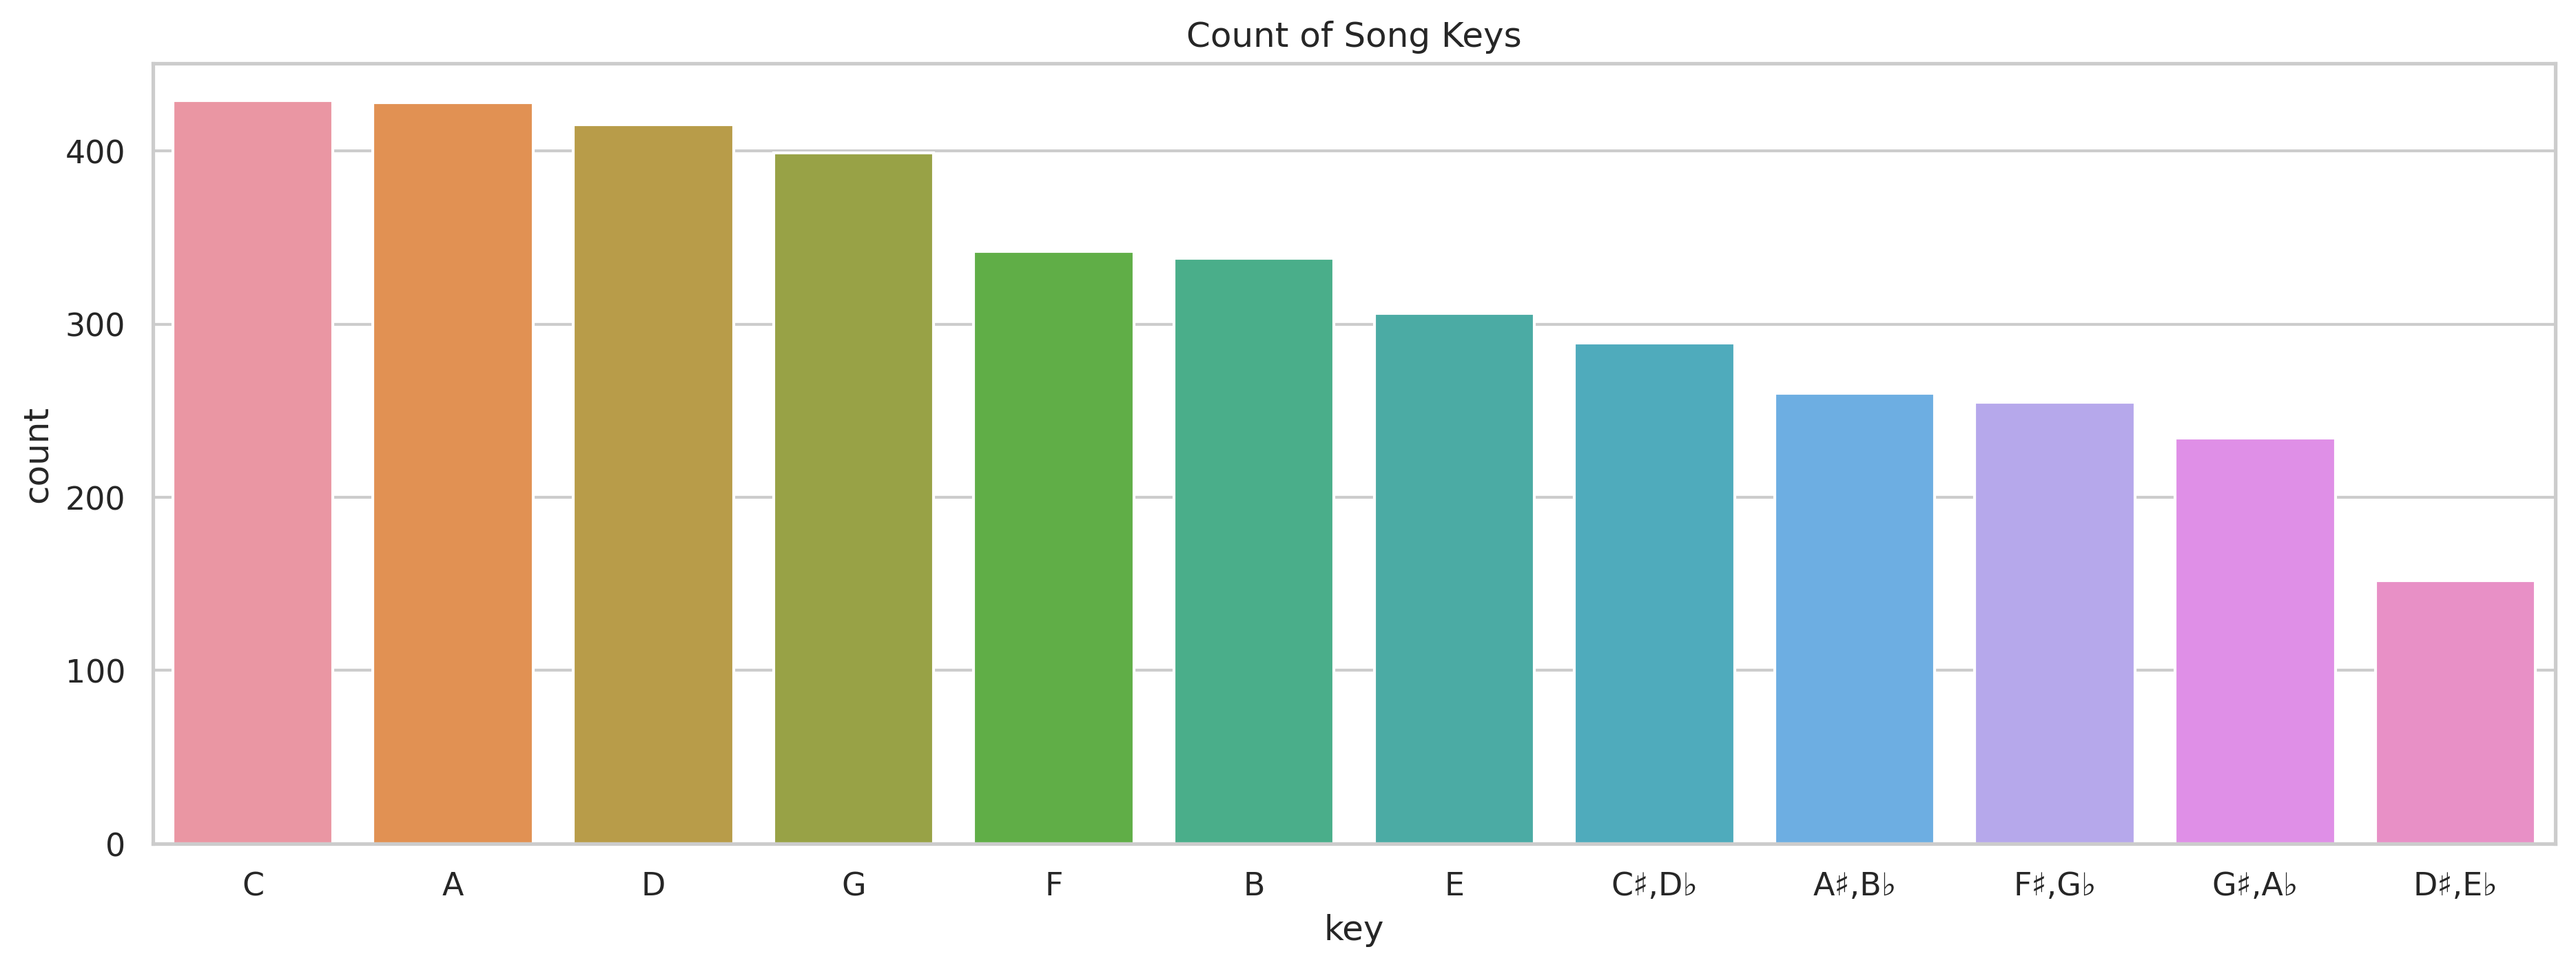

In [18]:
#map the numeric values of key to notes
key_mapping = {0: 'C', 1: 'C♯,D♭', 2: 'D', 3: 'D♯,E♭', 4: 'E', 5: 'F', 6: 'F♯,G♭', 7: 'G', 8: 'G♯,A♭', 9: 'A', 10: 'A♯,B♭', 11: 'B'}
vpop_df['key'] = vpop_df['key'].map(key_mapping)

sns.set_style({'font.family': ['sans-serif'], 'font.sans-serif': ['DejaVu Sans']})
sns.countplot(x = 'key', data=vpop_df, order=vpop_df['key'].value_counts().index)
plt.title("Count of Song Keys")
plt.show()

As shown above, the most common key among top tracks is C and A.

### Loudness

Mean value for loudness: -8.111603067325188


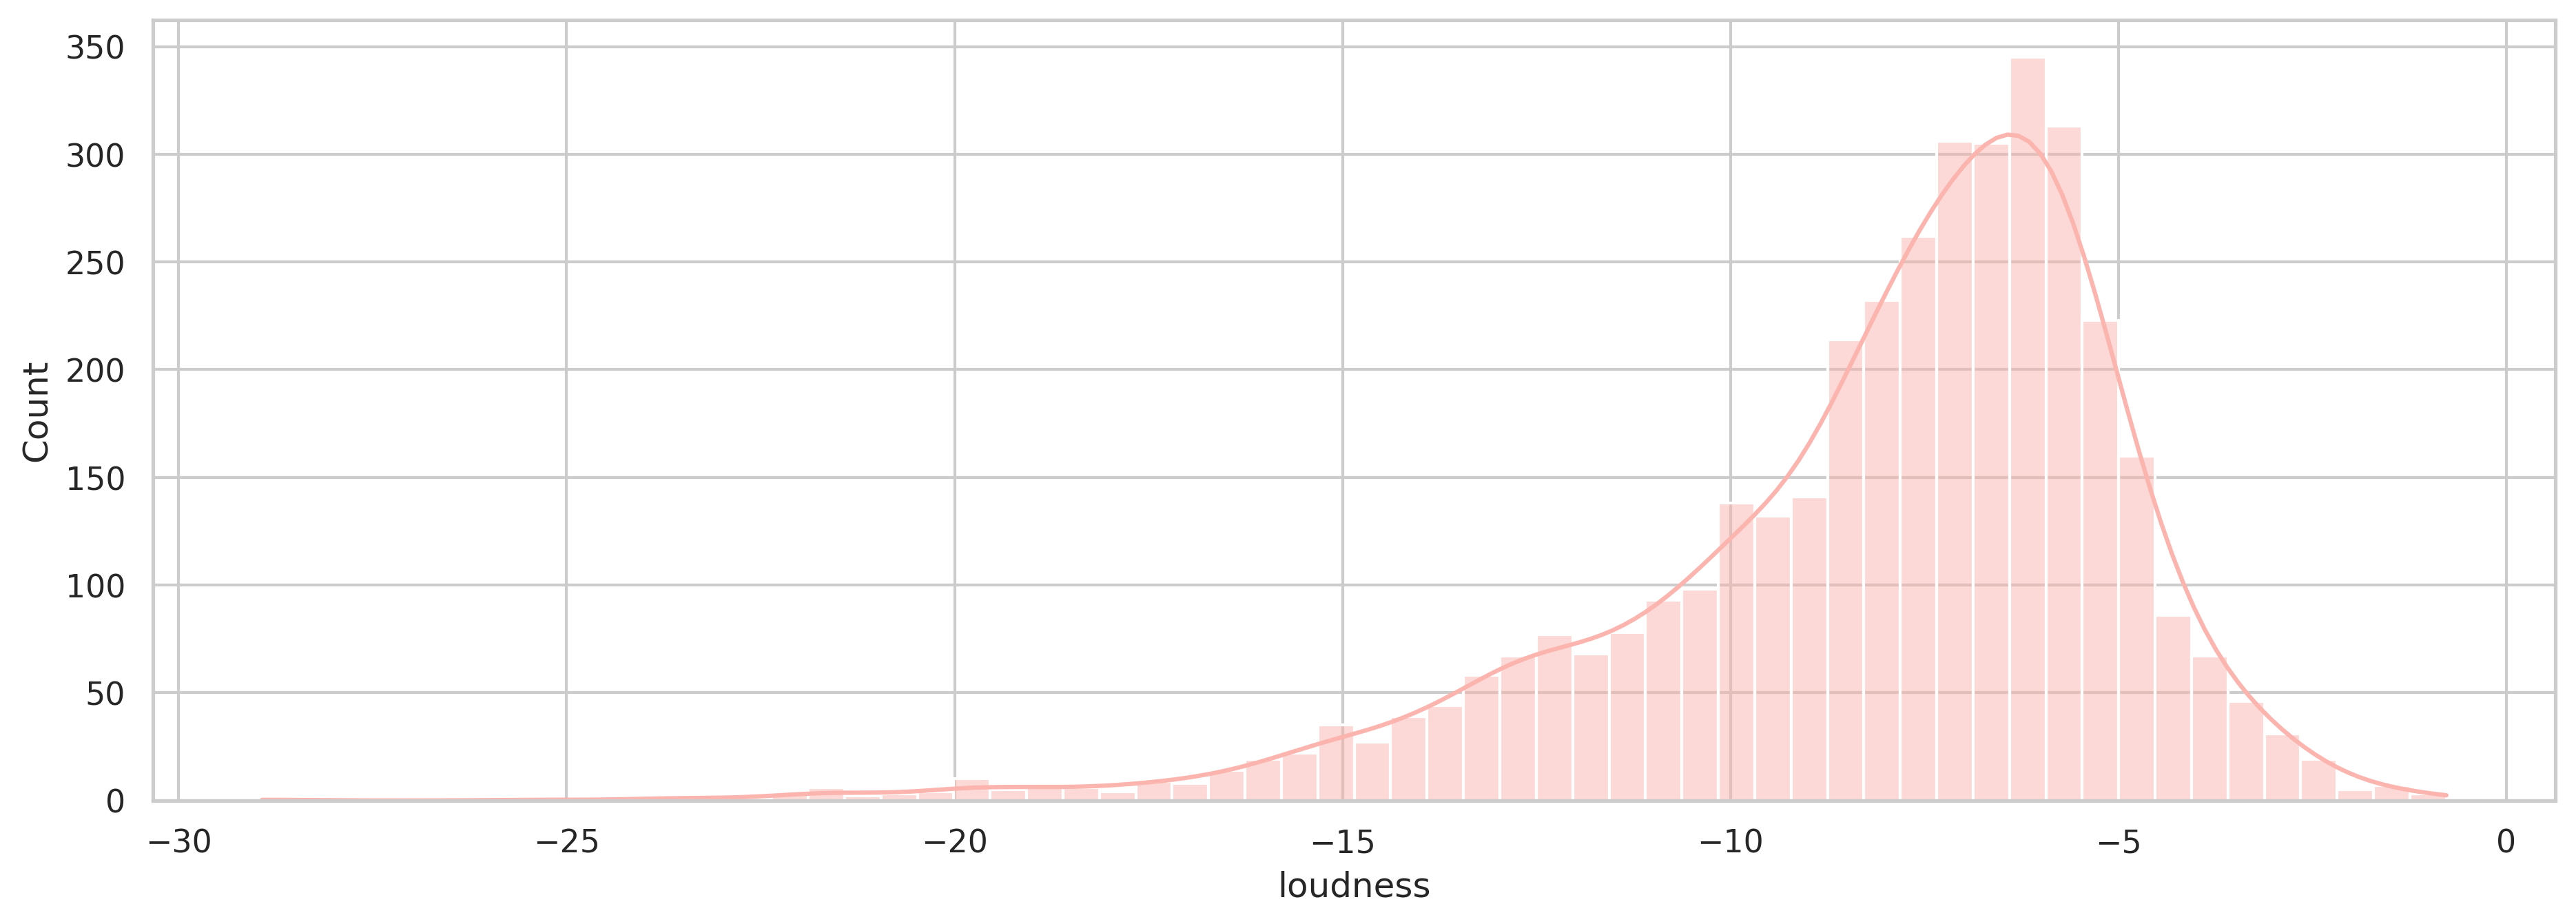

In [19]:
# mean value and histplot for loudness feature
print("Mean value for loudness:", vpop_df['loudness'].mean())
sns.histplot(vpop_df['loudness'], kde=True)
plt.show()

Most Vietnamese tracks have the loudness value of -8.11 dB.

### Mode

Mean value for mode feature: 0.4390434104497011


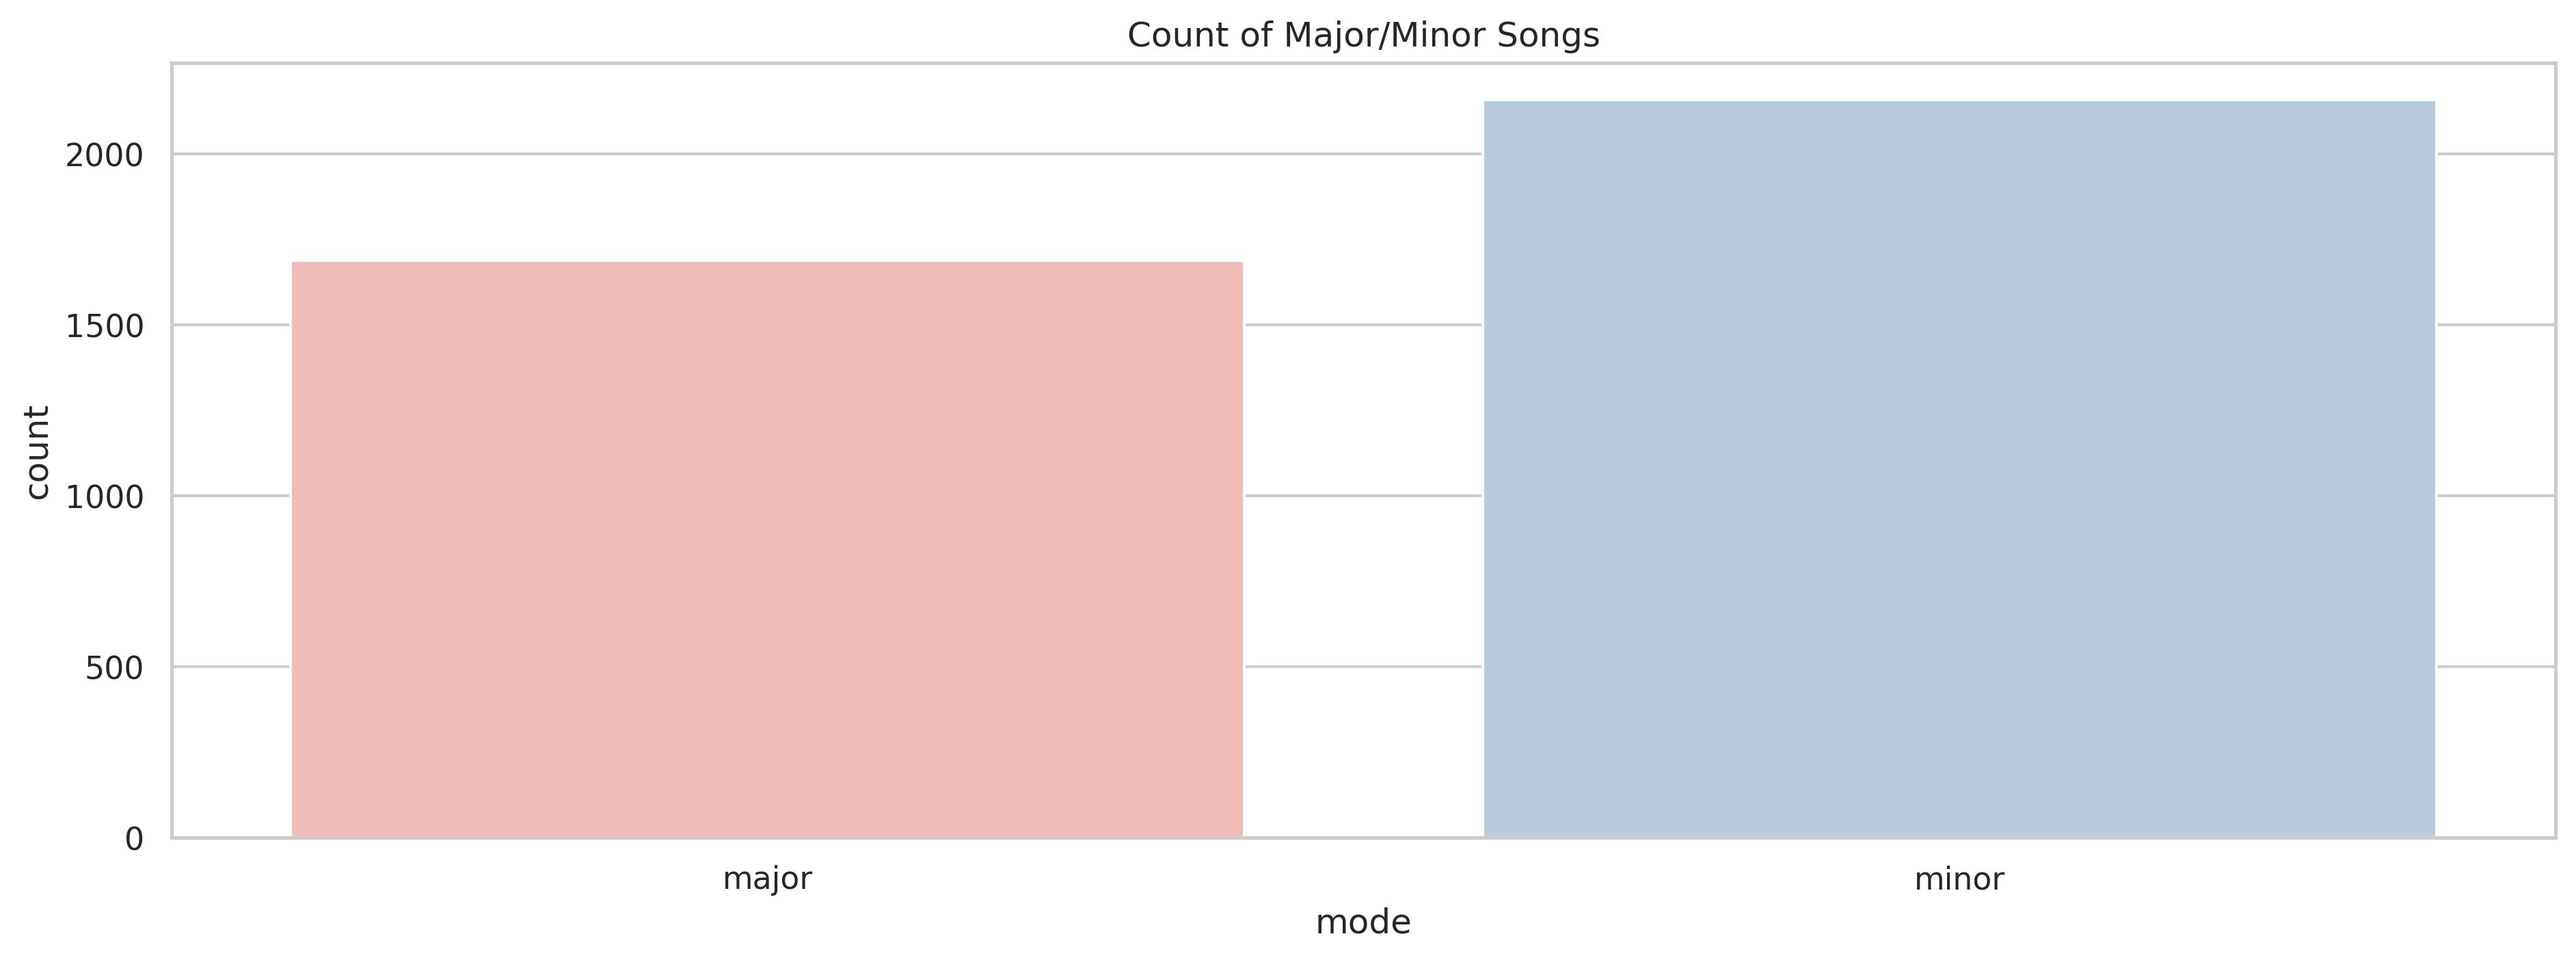

In [20]:
#print mean value for mode
print("Mean value for mode feature:", vpop_df['mode'].mean())

#map the binary value of mode to major/minor
mode_mapping = {1.0: "major", 0.0: "minor"}
vpop_df['mode'] = vpop_df['mode'].map(mode_mapping)

#draw a countplot of the values
sns.countplot(x = 'mode', data=vpop_df)
plt.title("Count of Major/Minor Songs")
plt.show()

Vietnamese preferred minor over major songs.

### Speechiness

Mean value for speechiness: 0.06464704964907726


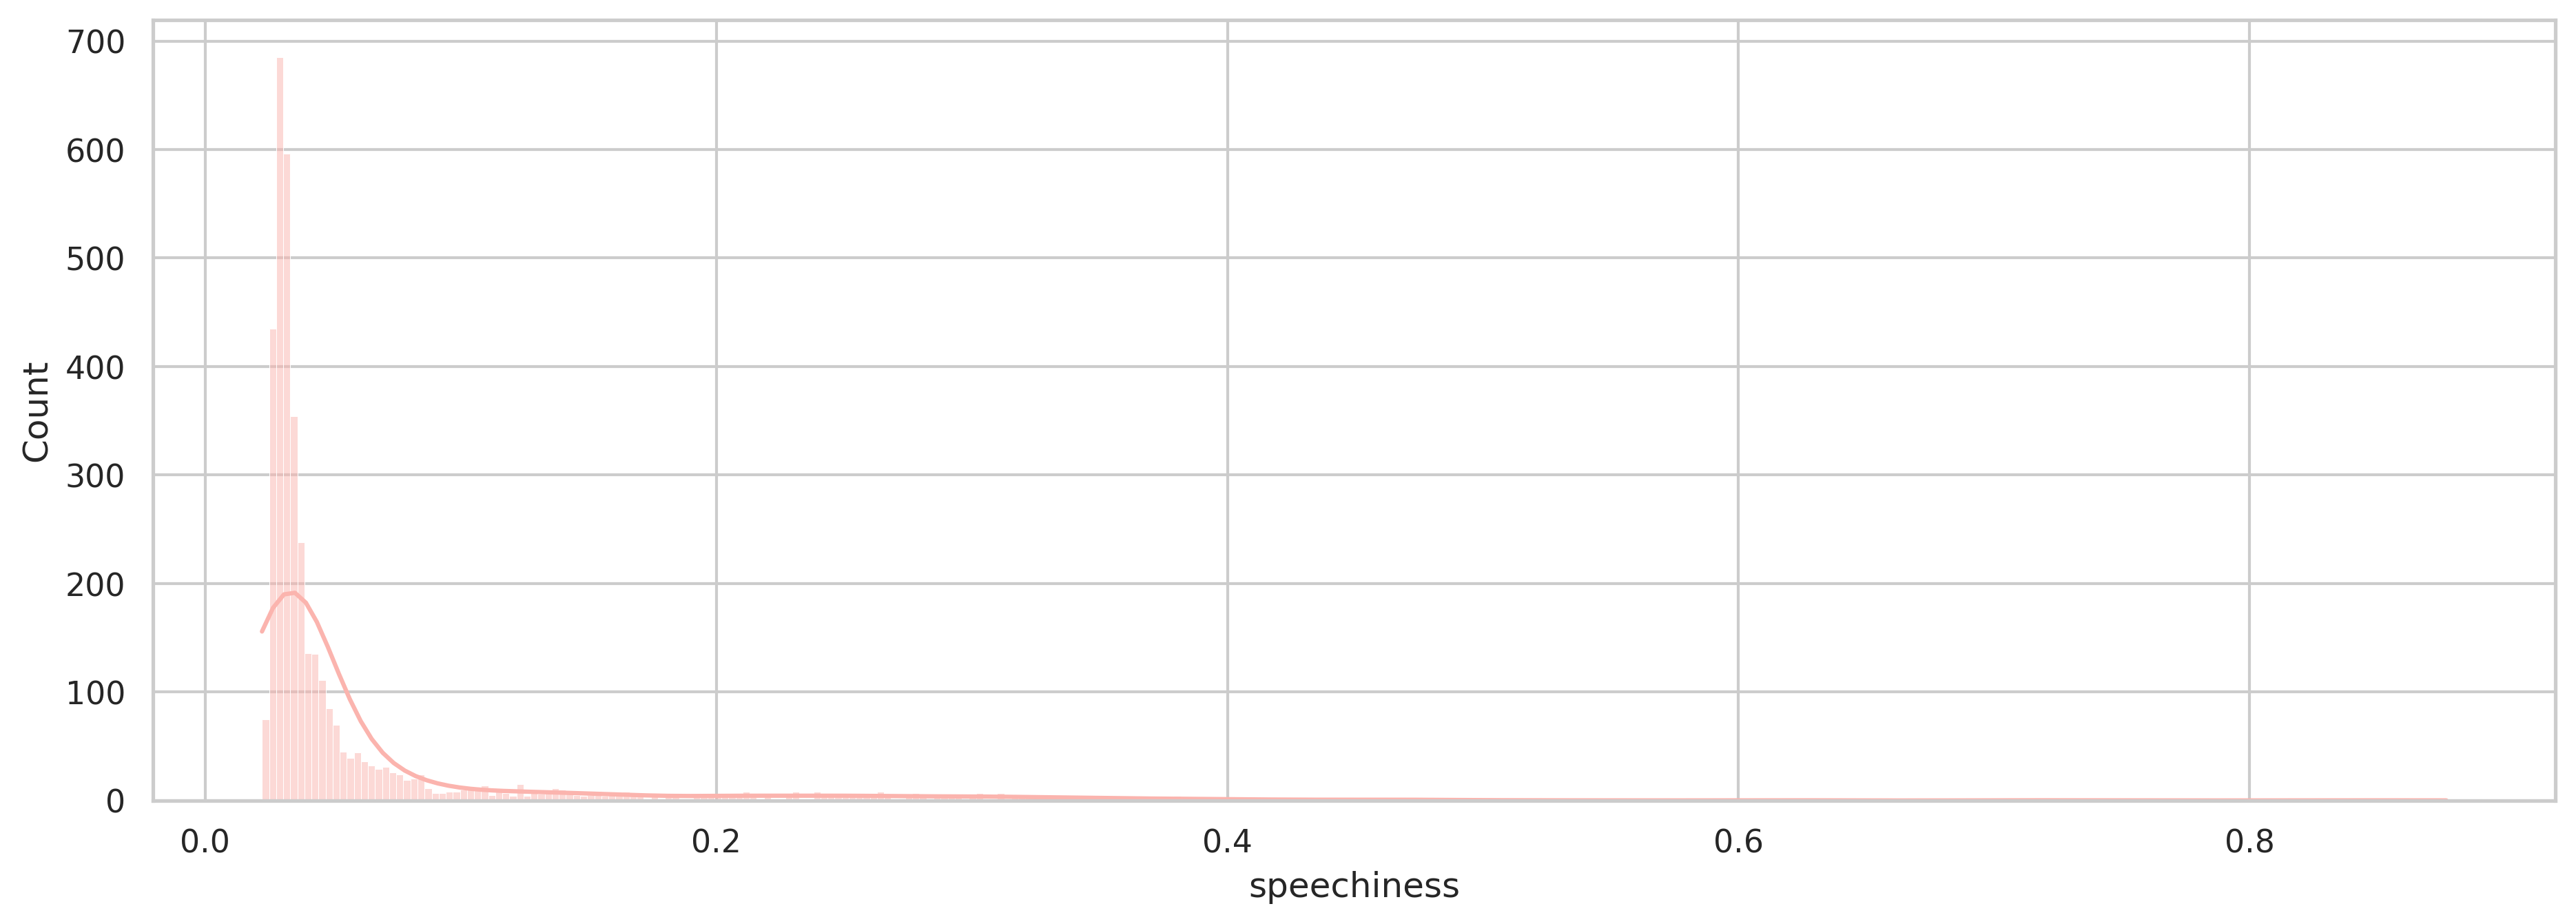

In [21]:
# mean value and histplot for speechiness feature
print("Mean value for speechiness:", vpop_df['speechiness'].mean())
sns.histplot(vpop_df['speechiness'], kde=True)
plt.show()

Since the mean value for speechiness is 0.065, we can conclude that most Vietnamese songs do not sound like an audio book, a poetry, or a talk show.

### Acousticness

Mean value for acousticness: 0.5177711497270591


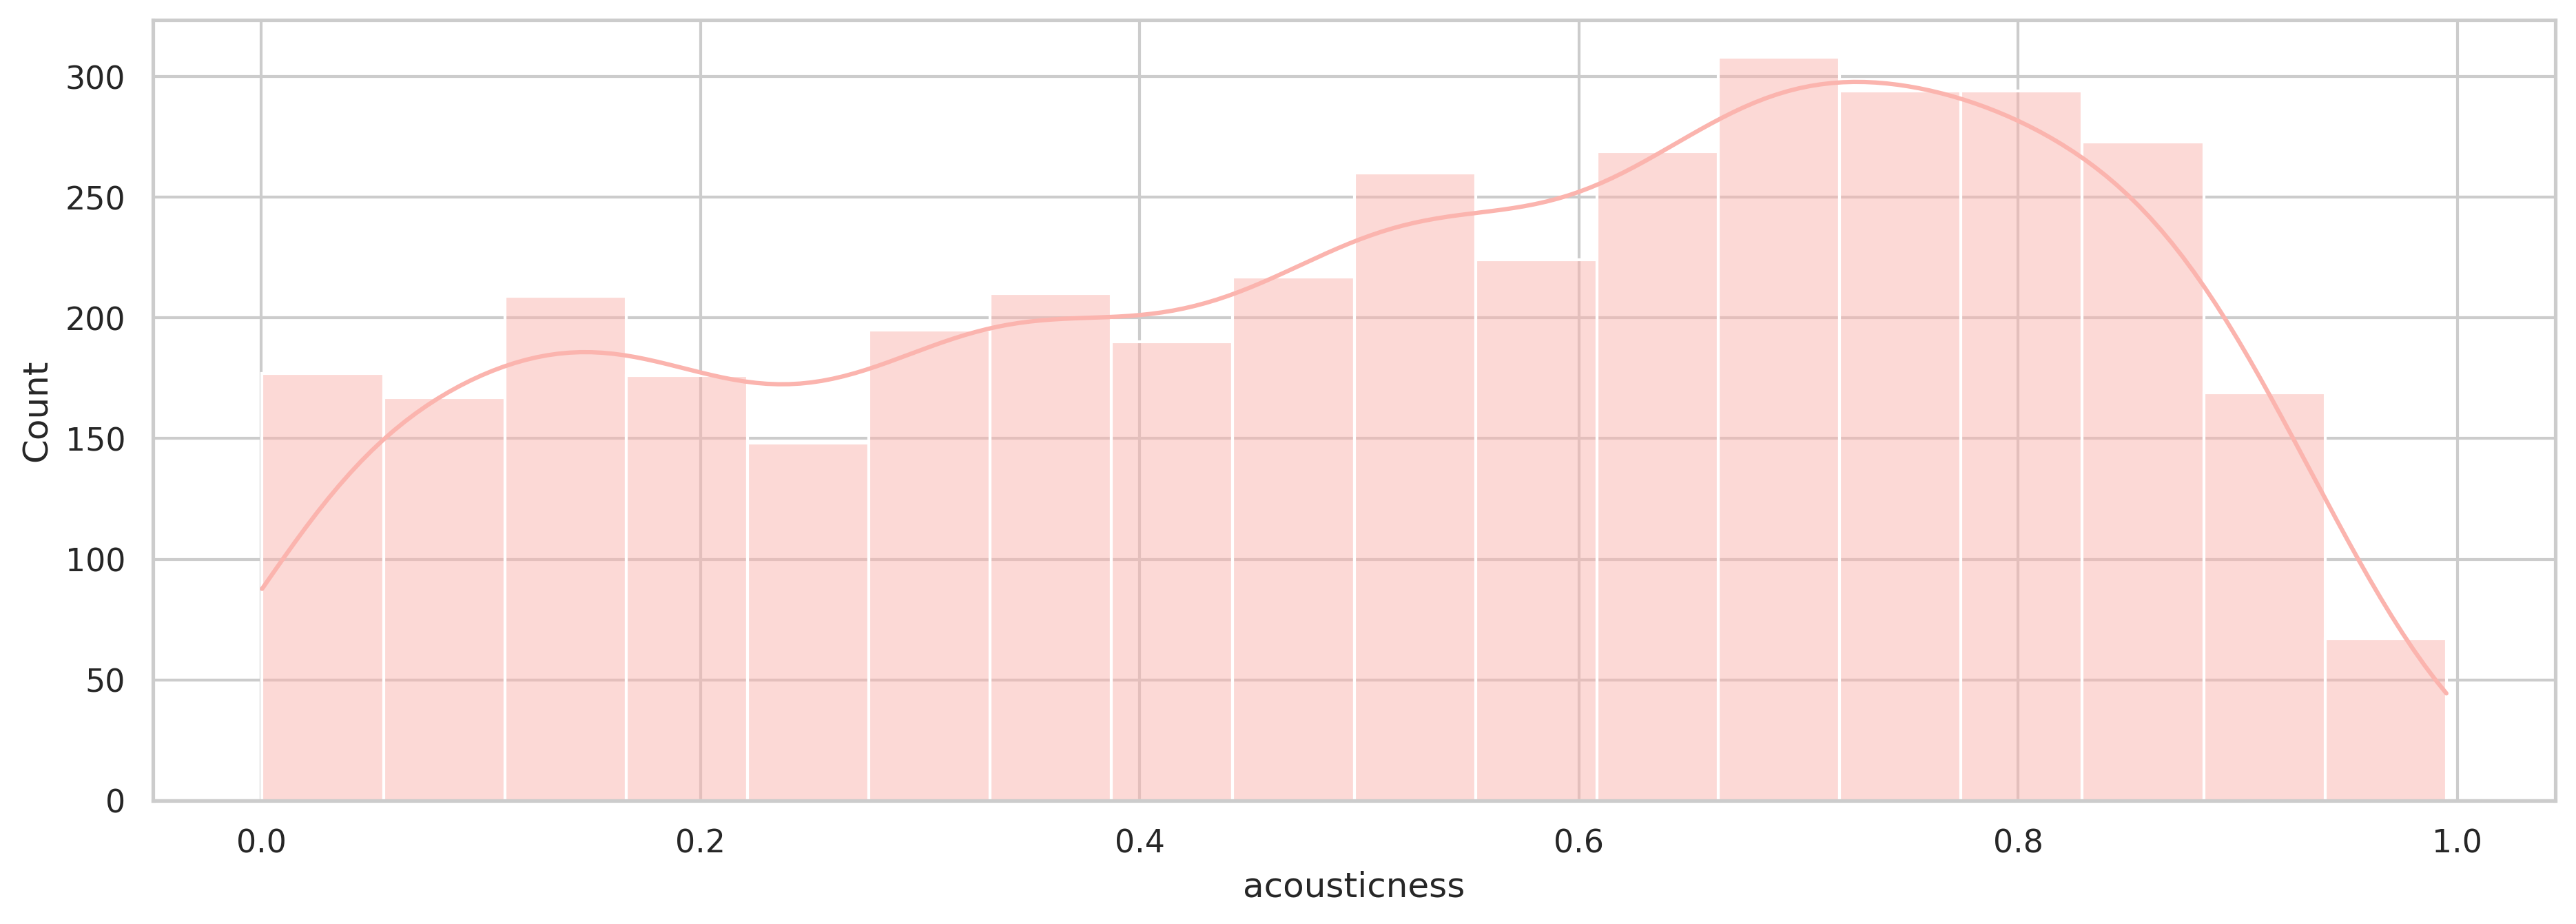

In [22]:
# mean value and histplot for acousticness feature
print("Mean value for acousticness:", vpop_df['acousticness'].mean())
sns.histplot(vpop_df['acousticness'], kde=True)
plt.show()

With a mean value of 0.518, Vietnamese folks seem to stream acoustic songs!

### Instrumentalness

Mean value for instrumentalness: 0.010526770046789731


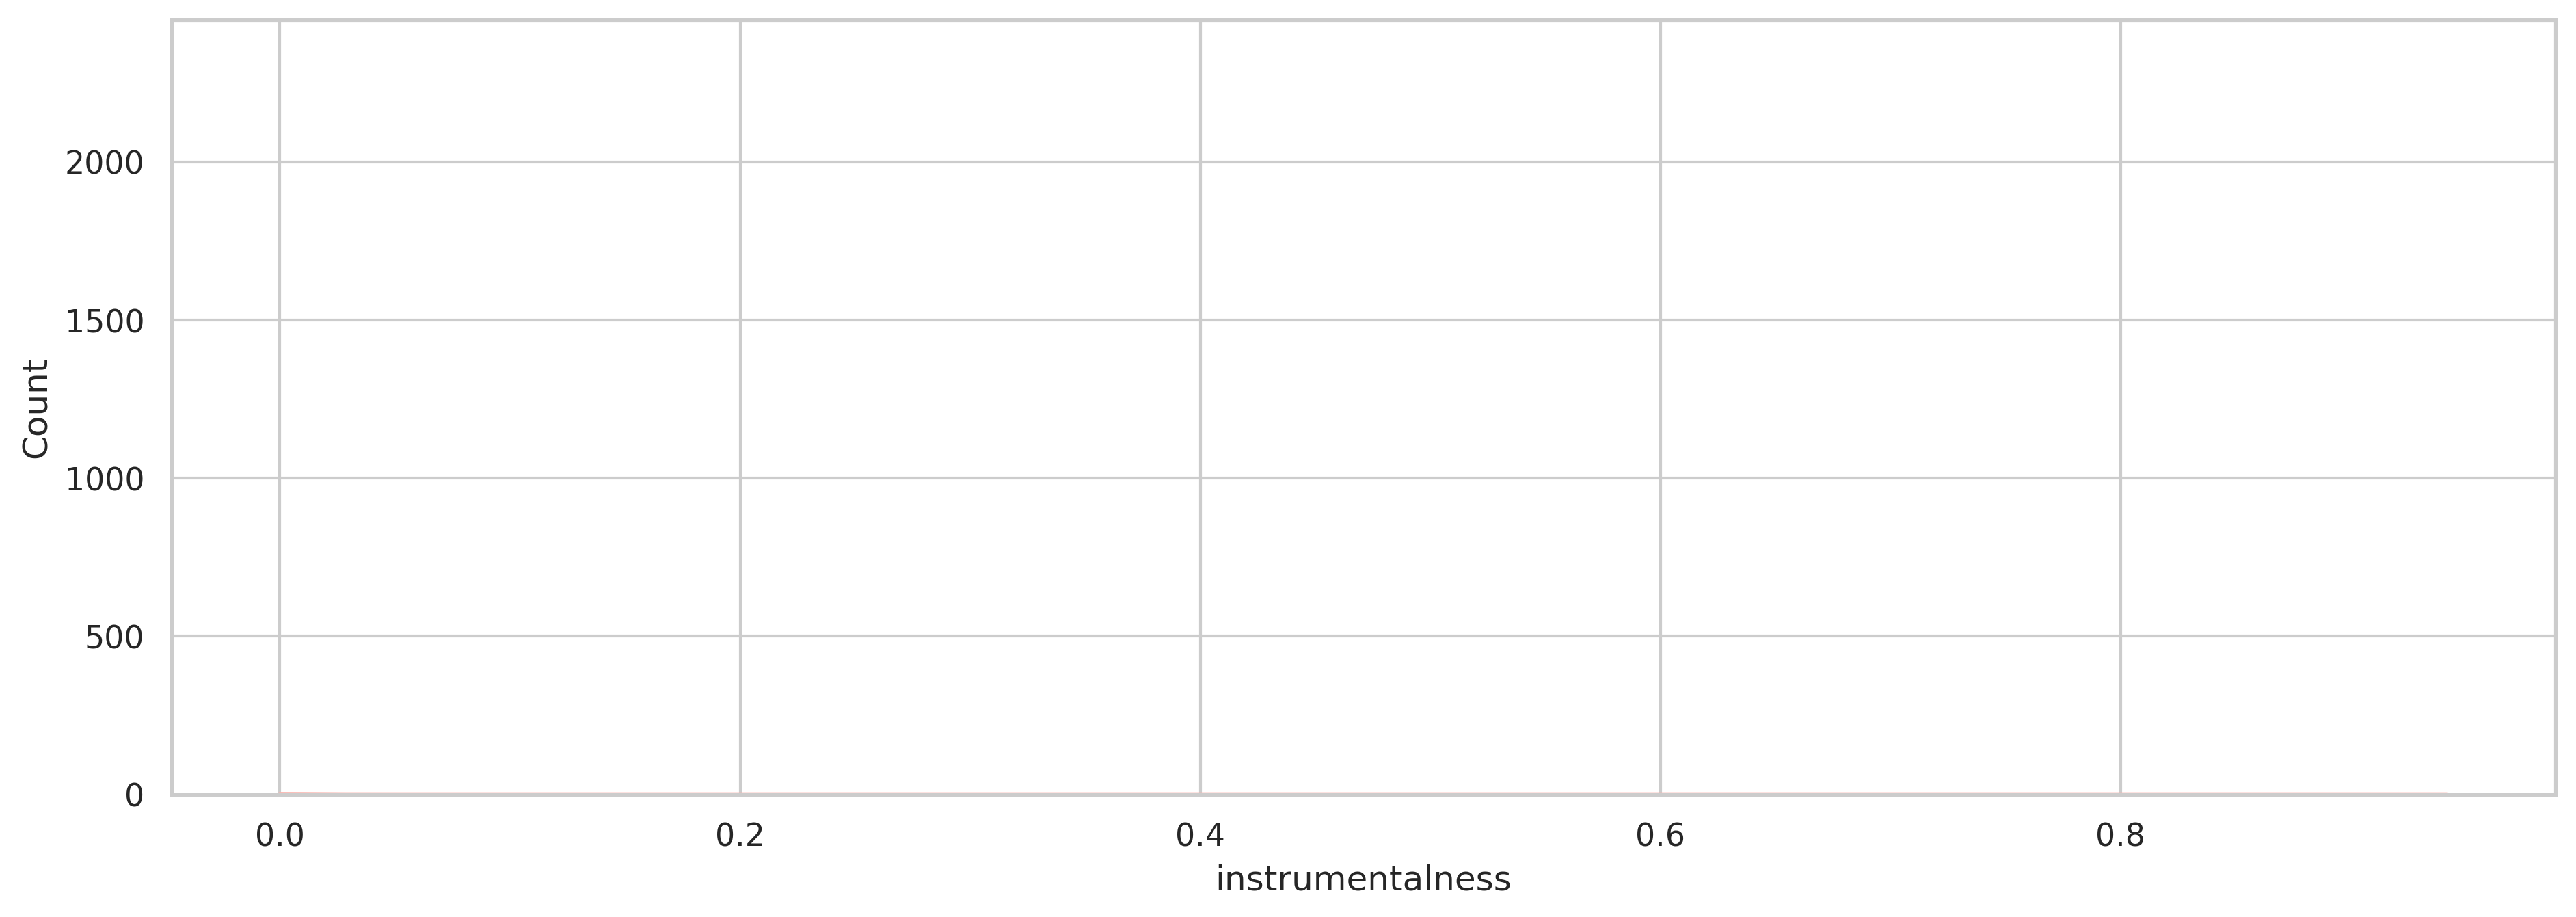

In [23]:
# mean value and histplot for instrumentalness feature
print("Mean value for instrumentalness:", vpop_df['instrumentalness'].mean())
sns.histplot(vpop_df['instrumentalness'], kde=True)
plt.show()

With mean value of 0.0105, we can conclude that most Vietnamese tracks contain vocal content.

### Valence

Mean value for valence feature: 0.37874556797504433


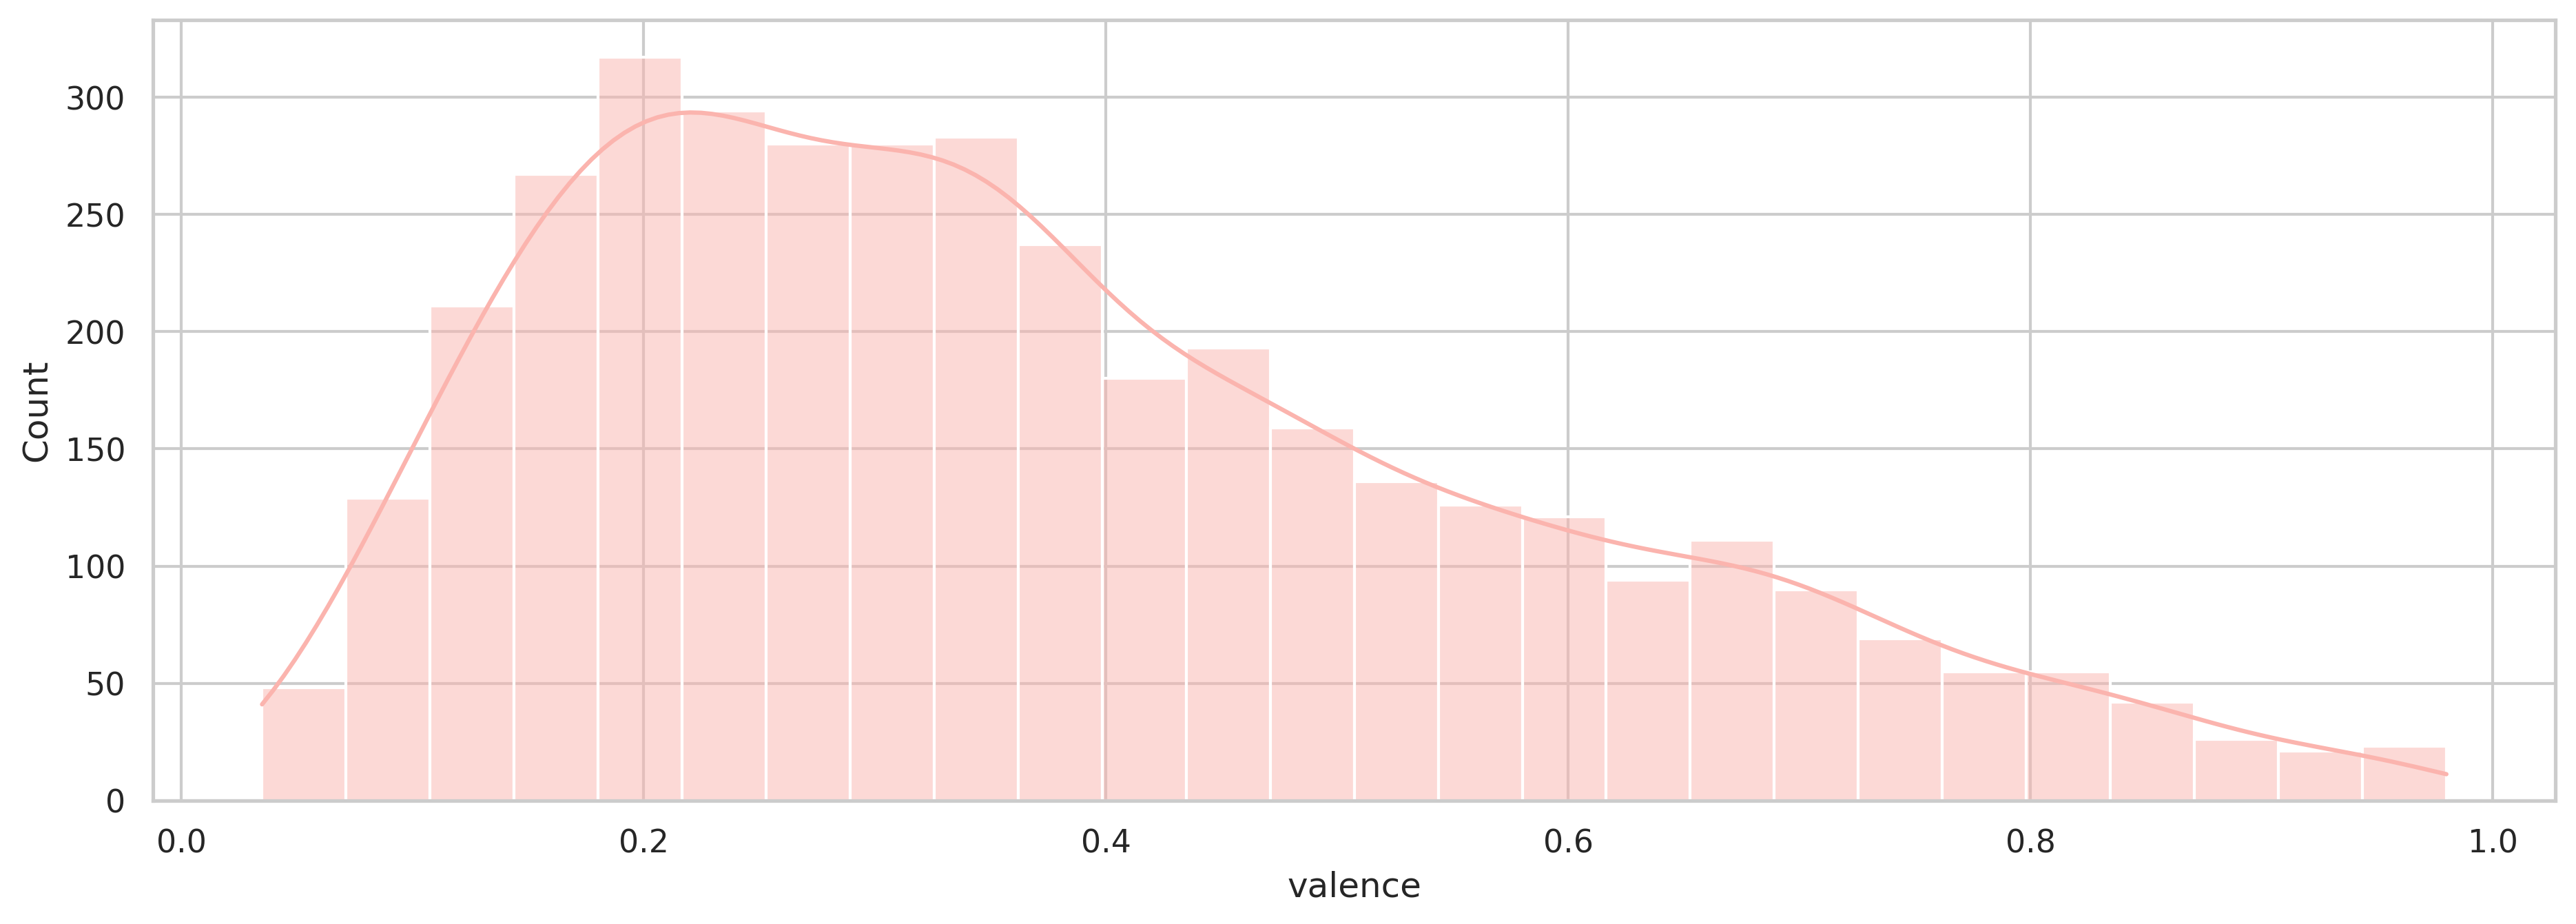

In [24]:
# mean value and histplot for valence feature
print('Mean value for valence feature:', vpop_df['valence'].mean())
sns.histplot(vpop_df['valence'], kde=True)
plt.show()

With a value of 0.379, happy and sad songs are not evenly distributed. 

### Tempo

Mean value for tempo feature: 120.96716636340034


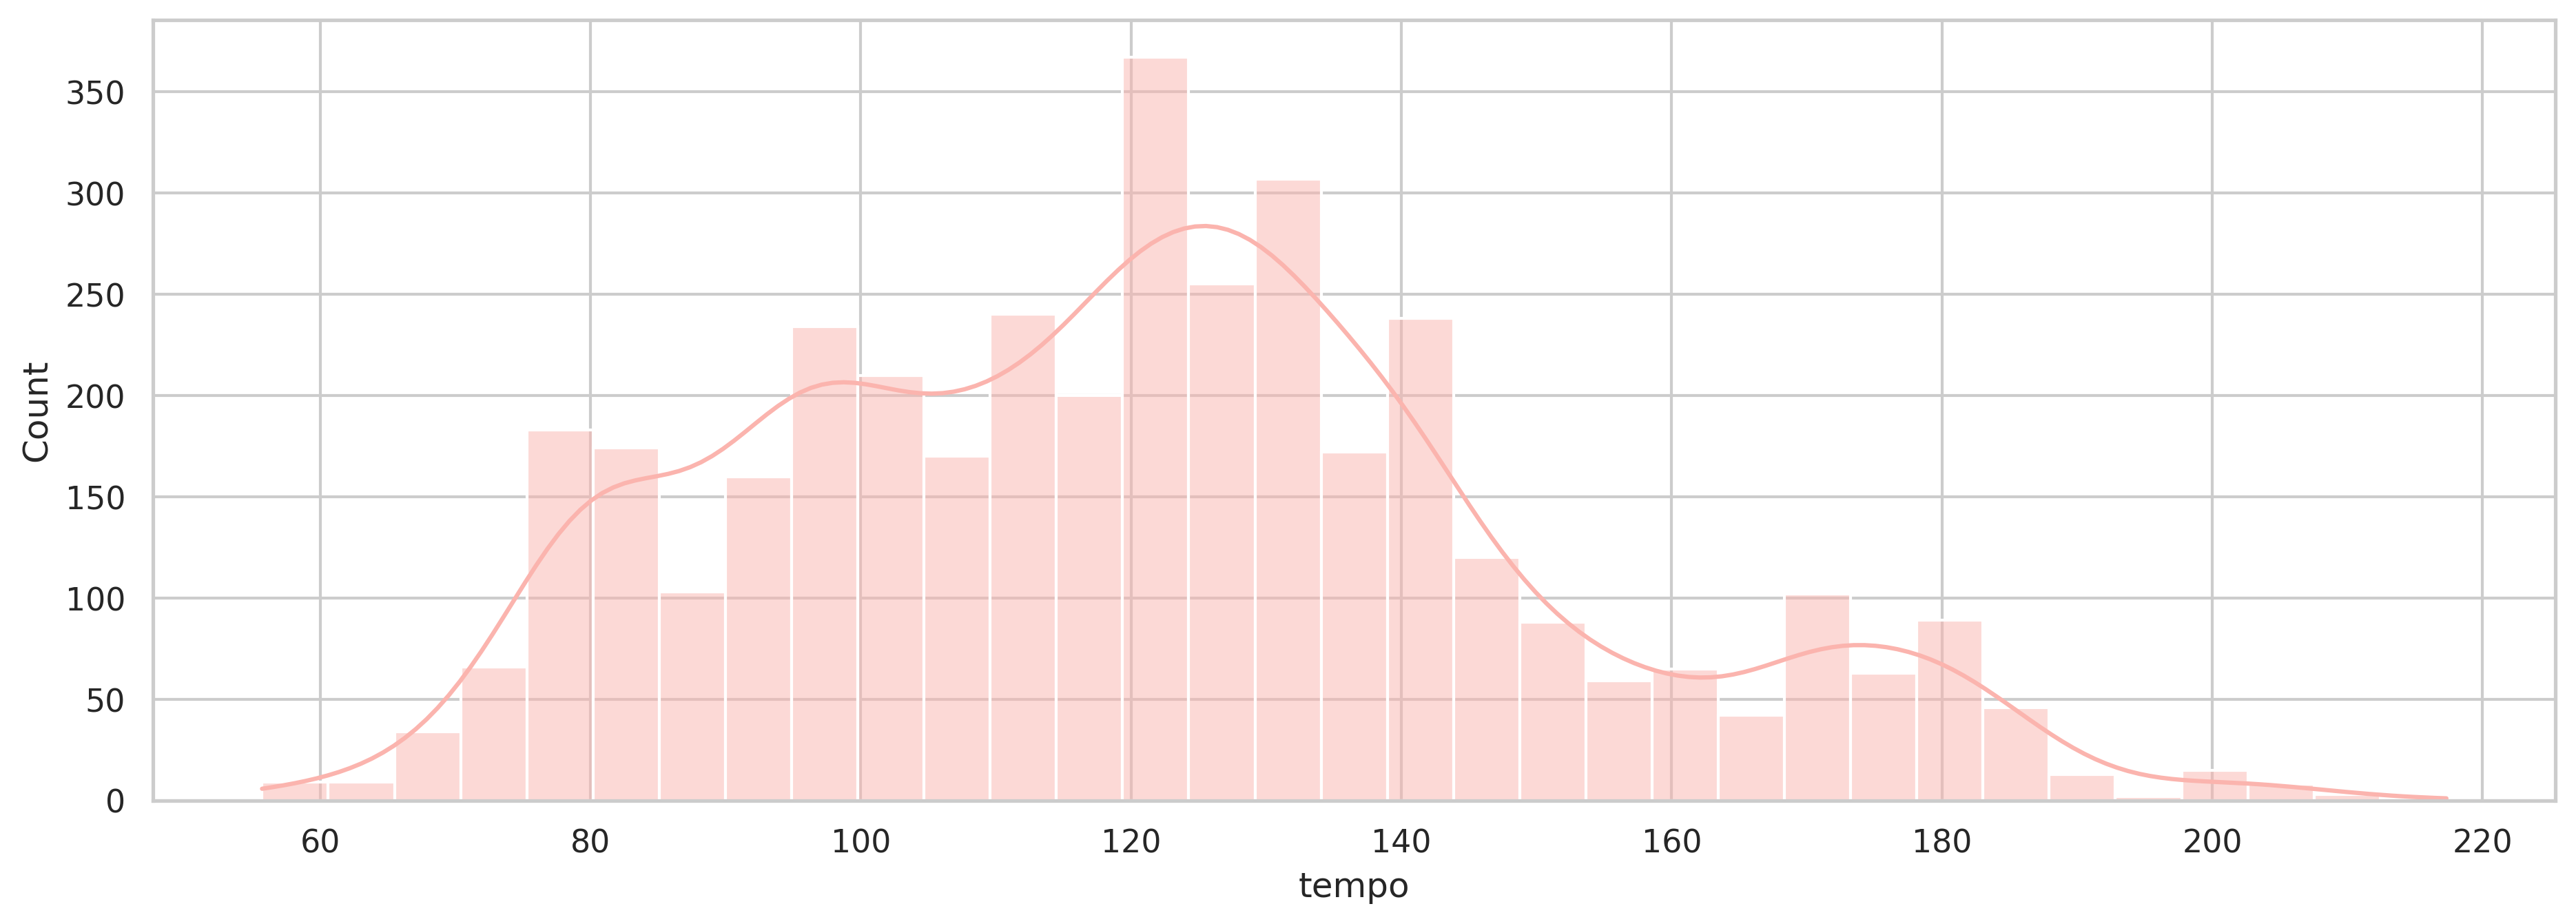

In [25]:
# mean value and histplot for tempo feature
print('Mean value for tempo feature:', vpop_df['tempo'].mean())
sns.histplot(vpop_df['tempo'], kde=True)
plt.show()

With the mean value of 120.97, we can tell that most tracks pretty fast. Perhaps Vietnamese people tend to listen to rap songs?

### Duration (Minute)

Mean value for duration_ms feature: 4.44167961181873


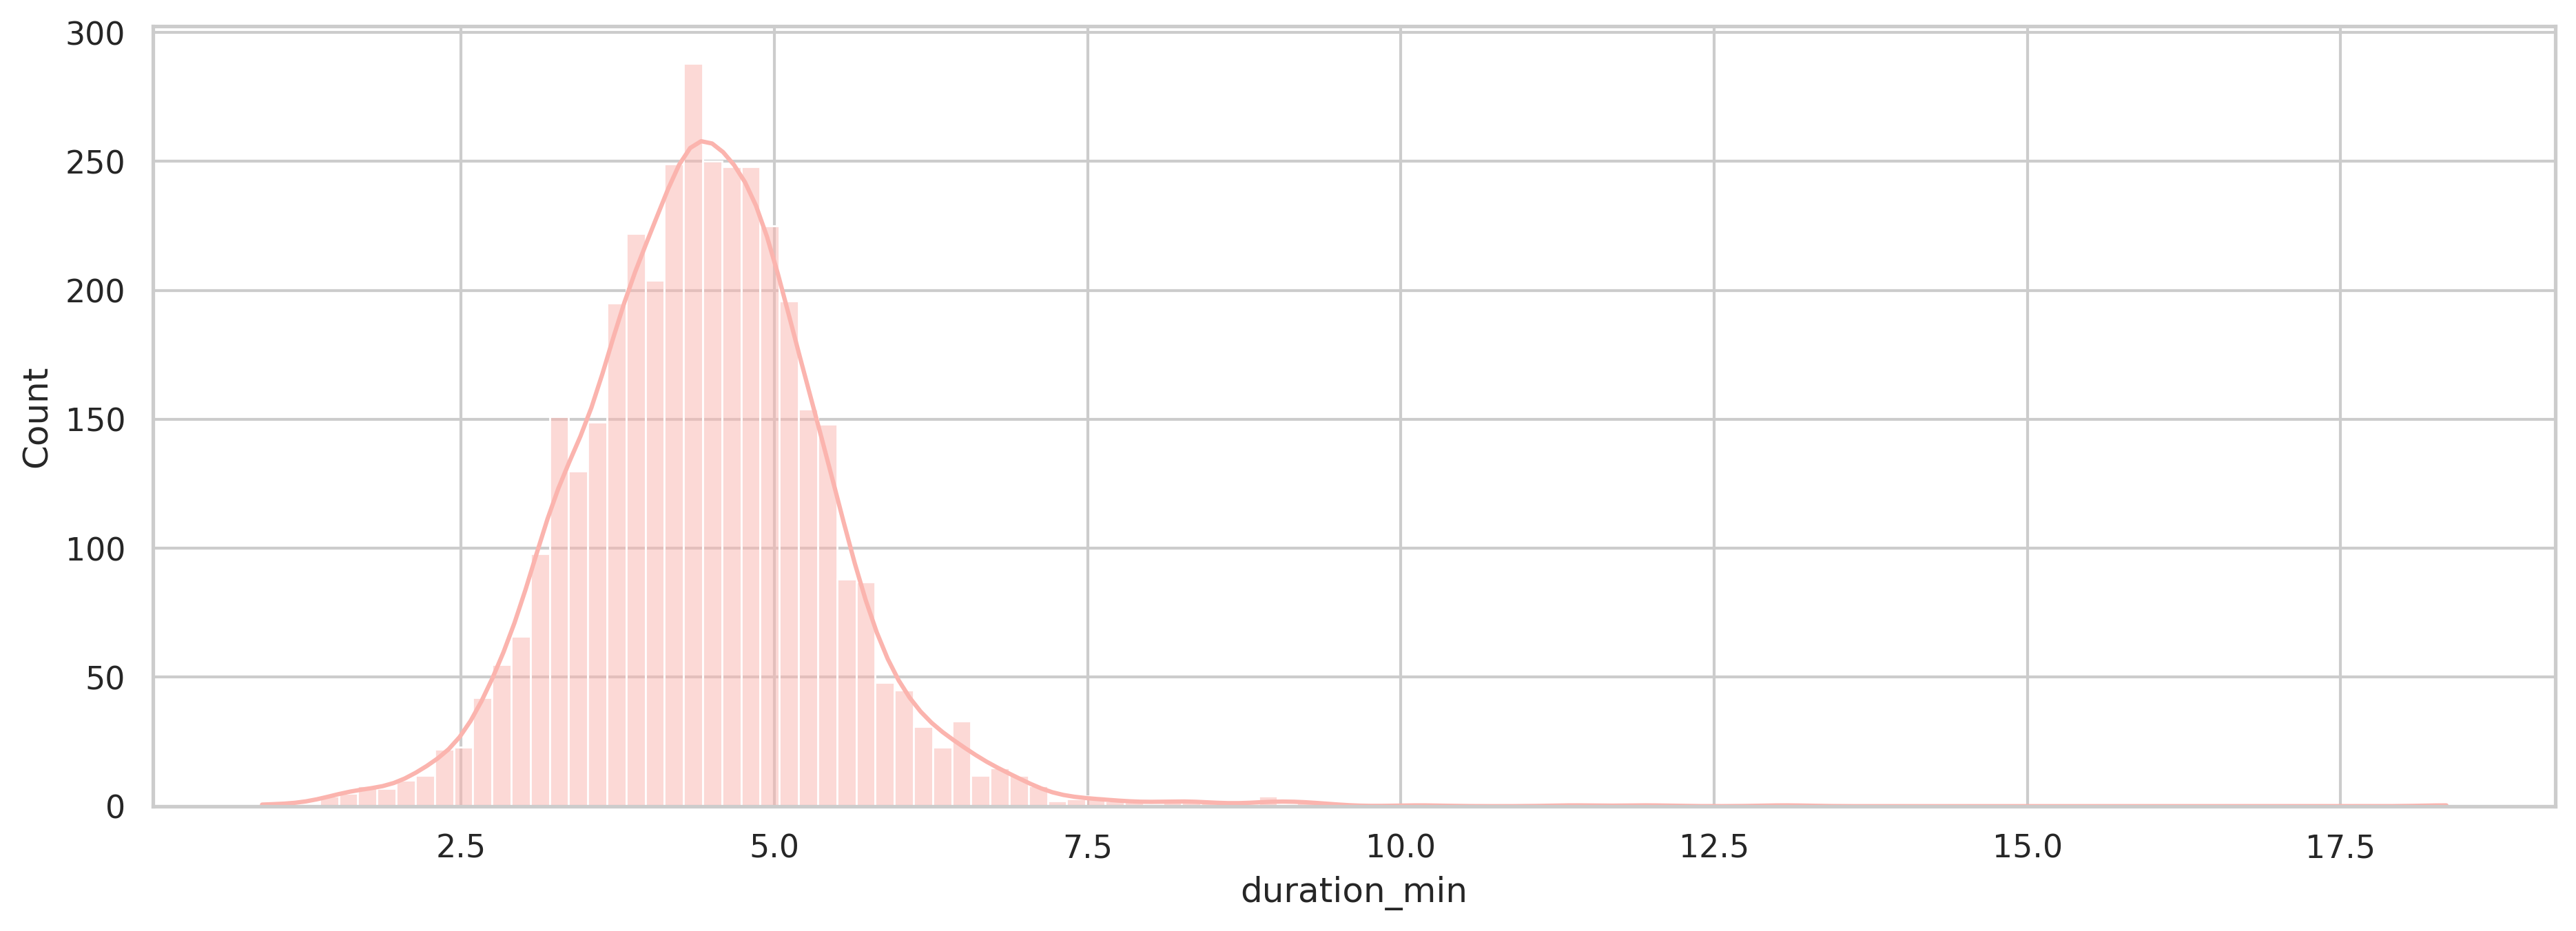

In [26]:
# mean value and histplot for duration_min feature
print('Mean value for duration_ms feature:', vpop_df['duration_min'].mean())
sns.histplot(vpop_df['duration_min'], kde=True)
plt.show()

With the mean of 4.44, which can be interpreted as 4 minutes and 44 seconds, we can assume that Vietnamese people prefer to listen to a long track.

### Correlation

In [27]:
corr = vpop_df.corr()
fig = go.Figure(data=go.Heatmap(z=corr.values,
                  x=corr.index.values,
                  y=corr.columns.values,
                  colorscale='Viridis'))
fig.update_layout(
    title='Correlation Between Song Features',
    xaxis_nticks=36)

fig.show()

Hmm, let's only focus on the correlation between two features with the correlation coefficient larger than 0.5. We can clearly notice that valence and danceability have the correlation coefficient of 0.6. Similarly, the correlation coefficient between loudness and energy is 0.69 (almost 0.7).

### Correlation Between Mood and Danceability

In [28]:
X = vpop_df['danceability'].values.reshape(-1, 1)

model = LinearRegression()
model.fit(X, vpop_df['valence'])

x_range = np.linspace(X.min(), X.max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))

fig = px.scatter(vpop_df, x='danceability', y='valence', opacity=0.65, title='Correlation between danceability and song mood')
fig.add_traces(go.Scatter(x=x_range, y=y_range, name='Regression Fit'))
fig.show()

In [29]:
X = vpop_df['loudness'].values.reshape(-1, 1)

model = LinearRegression()
model.fit(X, vpop_df['energy'])

x_range = np.linspace(X.min(), X.max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))

fig = px.scatter(vpop_df, x='loudness', y='energy', opacity=0.65, title='Correlation between loudness and song energy')
fig.add_traces(go.Scatter(x=x_range, y=y_range, name='Regression Fit'))
fig.show()

After fitting both models with a regression line, we can conclude that both of the models show the moderate to strong linear correlation. That being said, loudness and enegy features have a stronger correlation than danceability and valence features.

### Models

#### 3D

In [30]:
# Create a list of features and choose the text to display for each data point
features = ["energy", "liveness", "tempo", "valence", "loudness", "speechiness", "acousticness", "danceability", "instrumentalness"]
text = (vpop_df["names"] + " - " + vpop_df["artists"]).values

# Define X and y
X = vpop_df[features].values
y = vpop_df["danceability"].values

# Scale the data with MinMaxScaler
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

# Fit the model with PCA
pca = PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

# Plot
trace = go.Scatter3d(
    x=X[:,0],
    y=X[:,1],
    z=X[:,2],
    text=text,
    mode="markers",
    marker=dict(
        size=8,
        color=y,
        colorscale='gnbu'
    )
)

fig = go.Figure(data=[trace])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

With a list of features, we use principal component analysis (PCA) to reduce the dimensions of that list to 3. Then generated a 3D plot with a matrix suitable. In the above 3D plot, the lesser the distance between any two songs, the larger the similarities in their traits.

#### 2D

In [31]:
# Clustering Songs with K-Means
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=3, 
                                                    n_jobs=-1, 
                                                    max_iter= 100))])

X = vpop_df.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
vpop_df['cluster_label'] = song_cluster_labels

# Visualizing the Clusters with PCA
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = vpop_df['names']
projection['cluster'] = vpop_df['cluster_label']

C:\Users\tvo10\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).



In [32]:
# Show the plot
fig = px.scatter(projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

In this step, we are trying to cluster all the songs in this dataset in three groups. Based on my understanding, cluster 0 is comprised of songs that are belong to hip hop genre. Cluster 1 is comprised of songs that are belong to sentimental ballad genre. And Cluster 2 consists of songs that are belong to pop/ballad genre.

### References
* https://www.kaggle.com/aeryan/spotify-music-analysis
* https://www.kaggle.com/vatsalmavani/music-recommendation-system-using-spotify-dataset
* https://www.kaggle.com/nadintamer/what-makes-top-spotify-songs-popular
* https://github.com/sunkusowmyasree/Spotify_Capstone_Project/blob/main/Spotify_Capstone_Project.ipynb